# Importing the dataset from kaggle

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'my-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3335645%2F6380242%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240305%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240305T113615Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9fcc82b219a6984b2e9f264c729b69a18e5ccddd9131b5dd6d4f7f099211581bcf47c68094adb7b4590c05a69234fc1951ea9e7b5dade0c22b248d8040e900b0c8c3d9179ced389e93746dd269e1772bf4d75f79158e4d06ebf13edfc82b3c8c642afe0cdae215a4adbe32b89744670349a3b31fc99666461fc5d42fd28491df4445cca64b472ce977cad06ff004c9dc7a4f7f5888ac1b00bf7639db8dfc3d5019b46db28973d0ee1651e0e84a8722794e37424fff0d3afa6a5a75e80620117baf94f6a45f36f0b1b8f7d9245348a7717da7bf088387cd6e64d447424b1a2a8814bd71f8b6081628b2f0364a3821c1a25f962c03f73ac8bfc4452c0152c256a3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 11896802 bytes downloaded
Downloaded and uncompressed: my-dataset
Data source import complete.


# Importing all the necessary libraries

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_score, cross_val_predict

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix


from sklearn.preprocessing import StandardScaler

# Data Preperation

In [ ]:
train_df = pd.read_csv("/kaggle/input/my-dataset/train_dataset_combined.csv")
test_df = pd.read_csv("/kaggle/input/my-dataset/test_dataset_combined.csv")

In [ ]:
train_df.head()

,SESSION_ID,EVENT_DATETIME,TRANSACTION_ID,FRAUD_FLAG,AVAIL_CRDT,AMOUNT,CREDIT_LIMIT,CARD_NOT_PRESENT,FLAG_LX,FLAG_ATM,...,TIMESTAMP_MAX,PAGE_NAME,BROWSER_FAMILY,BROWSER_VERSION,OS_FAMILY,DEVICE_FAMILY,DEVICE_BRAND,DEVICE_MODEL,CITY,TIME_SPENT
0,9cc2c261-b73e-4f73-94c7-cc5d78e01148,2022-03-02 15:40:49,71f8a325e,1.0,7420.73,69.70,14600.0,1,0,0,...,2022-03-02 15:47:22,"{'checkout', '2-factor-authentication', 'home-...",Mobile Safari,16.0,iOS,iPhone,Apple,iPhone,montreal,393.0
1,f3fc1ca4-5e08-42d8-bf5d-bc5026a377b5,2022-07-04 07:51:19,2b4a3e059,0.0,3825.90,1.02,7300.0,1,0,0,...,2022-07-04 08:08:03,"{'checkout', 'home-page', 'view-product', 'sea...",Mobile Safari UI/WKWebView,NaN,iOS,iPhone,Apple,iPhone,brampton,1004.0
2,b8e5bcaf-1c22-4413-be36-df6f00afc622,2022-06-02 10:20:34,545cef560,0.0,115.83,33.15,1300.0,1,0,0,...,2022-06-02 10:41:37,"{'checkout', '2-factor-authentication', 'home-...",Edge,106.0.1370,Windows,Other,NaN,NaN,brampton,1263.0
3,40b48620-202f-429f-a890-5ad013d8817d,2022-05-28 12:00:41,6058a9fe1,0.0,28114.72,514.55,30700.0,1,0,0,...,2022-05-28 12:16:37,"{'checkout', 'home-page', 'view-product', 'sea...",Android,11,Android,Generic Smartphone,Generic,Smartphone,montreal,956.0
4,2417e156-fd74-4b7d-a772-c995f8ce56ea,2022-05-21 17:12:23,3aa3e59fe,0.0,145.28,187.57,15300.0,1,0,0,...,2022-05-21 17:31:37,"{'checkout', '2-factor-authentication', 'home-...",Mobile Safari UI/WKWebView,NaN,iOS,iPhone,Apple,iPhone,regina,1154.0


## 1. Analyzing Target Column

percentage of fraud (1.0) and non-fraud(1.0) cases in the dataset:
0.0    92.29
1.0     7.71
Name: FRAUD_FLAG, dtype: float64



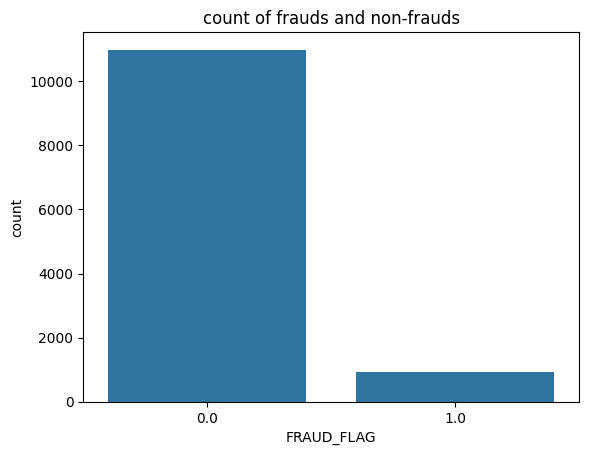

In [ ]:
print("percentage of fraud (1.0) and non-fraud(1.0) cases in the dataset:")
print(round(train_df["FRAUD_FLAG"].value_counts(normalize=True)*100, 2))
print()

sns.countplot(data=train_df, x="FRAUD_FLAG")
plt.title("count of frauds and non-frauds")
plt.show()

Since, the number of fraud transactions are way less than normal

Given our context, key metrics being evaluated comprise precision, recall, F1-score, and AUC-ROC score. The decision on which metric to prioritize depends on the specific requirements of our business domain. In our scenario, the F1-score emerges as the focal point. This metric effectively balances precision and recall, aligning well with our objective of thorough fraud detection.

### Checking Duplicates

In [ ]:
train_df.duplicated().sum()

0

Simplifying Data: Removing Unnecessary Columns¶

As our analysis progresses, we continuously refine our dataset. In our quest for a more targeted and streamlined exploration, we've pinpointed columns that have completed their tasks and are no longer pertinent to our current goals.

The SESSION_ID, previously crucial for data amalgamation, has fulfilled its purpose and is now superfluous to our analysis. Likewise, the TRANSACTION_ID, initially reserved for future model submissions, does not aid in our ongoing exploration. To streamline our dataset, we have opted to discard these redundant columns.







In [ ]:
train_df.drop(["SESSION_ID", "TRANSACTION_ID"], axis=1, inplace=True)
test_df.drop(["SESSION_ID", "TRANSACTION_ID"], axis=1, inplace=True)

## 2. Evaluating Missing Values


Dealing with missing values is akin to filling in missing puzzle pieces within our dataset. Our exploration of this data would be incomplete without addressing these informational gaps.

We start by systematically removing columns where over 50% of the values are missing. This practical method streamlines our analysis, allowing us to concentrate our efforts where the data is most reliable.

In [ ]:
missings = pd.DataFrame((train_df.isna().mean()*100).sort_values(ascending=False), columns=["missing %"])
missings

,missing %
BROWSER_VERSION,63.471394
DEVICE_MODEL,10.199109
DEVICE_BRAND,10.199109
EVENT_DATETIME,0.000000
STD_ENTERTAINMENT_PAST_30DAY,0.000000
...,...
STD_FASTFOOD_PAST_7DAY,0.000000
STD_HIGH_AMT_PAST_7DAY,0.000000
STD_INTERNET_PAST_7DAY,0.000000
STD_LOW_AMT_PAST_7DAY,0.000000


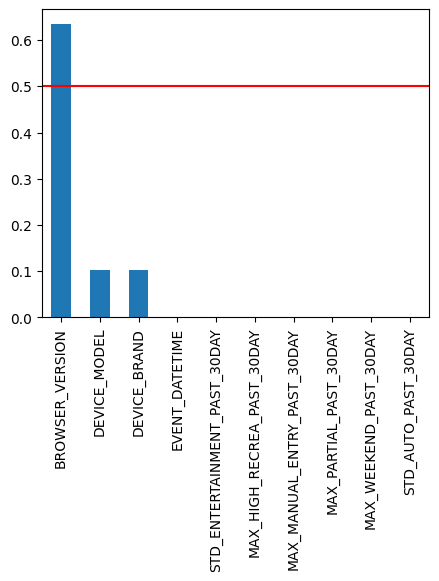

In [ ]:
train_df.isnull().mean().sort_values(ascending=False).head(10).plot(kind="bar", figsize=(5,4))
plt.axhline(y=0.5, color="red")
plt.show()

In [ ]:
train_df.drop(["BROWSER_VERSION"], axis=1, inplace=True)
test_df.drop(["BROWSER_VERSION"], axis=1, inplace=True)

## 3. Feature Categorization and Correlation Analysis

**Simplifying Uniqueness: Zeroes and Ones (this happens in columns with all NaN)**
**Hypothesis**: ML model is not able to learn from columns with only one unique value. We'll keep the columns for now, but in the training phase, we'll remove the columns to see if the model performance changes or not.

In [ ]:
one_or_zer_unique_val_features = [col for col in train_df.columns if train_df[col].nunique() <= 1]
one_or_zer_unique_val_features

['CARD_NOT_PRESENT',
 'FLAG_ATM',
 'FLAG_CASH',
 'FLAG_RECREA',
 'FLAG_FASTFOOD',
 'FLAG_GAS',
 'FLAG_HIGH_RECREA',
 'FLAG_INTERNET',
 'FLAG_MANUAL_ENTRY',
 'FLAG_SWIPE']

In [ ]:
train_df["FLAG_ATM"].value_counts()

0    11903
Name: FLAG_ATM, dtype: int64

### Grouping Columns By Category

By grouping columns into categories, we're setting the stage for some efficient Exploratory Data Analysis (EDA). There are 21 "flag" columns in the dataset. We'll create 21 categories First. The non-flagged columns are categorized into "other" columns

In [ ]:
flag_columns = list(train_df.filter(regex=r"^FLAG").columns)
print("number of flags:", len(flag_columns))
print()
print("name of flags")
print(flag_columns)
print()

lx_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("lx")])
atm_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("atm")])
auto_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("auto")])
cash_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("cash")])
apparel_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("apparel")])
deal_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("deal")])

entertainment_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("entertainment")])
gift_card_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("gift_card")])
fastfood_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("fast")])
gas_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("gas")])
high_amt_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("high_amt")])

high_recrea_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("high_recrea")])
temp = list(train_df.columns[train_df.columns.str.lower().str.contains("recrea")])
recrea_columns = [col for col in temp if col not in high_recrea_columns]

internet_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("internet")])
international_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("international")])
fashion_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("fashion")])
low_amt_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("low_amt")])
manual_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("manual")])
elctrncs_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("elctrncs")])
swipe_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("swipe")])
health_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("health")])

weekend_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("weekend")])
partial_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("partial")])

print("number of columns in train_df:", len(train_df.columns))
print("number columns in categories:", len(lx_columns) + len(atm_columns) + len(auto_columns) + len(cash_columns) + len(apparel_columns) + len(deal_columns)\
      + len(recrea_columns) + len(entertainment_columns) + len(gift_card_columns) + len(fastfood_columns) + len(gas_columns) + len(high_amt_columns)\
      + len(high_recrea_columns) + len(internet_columns) + len(international_columns) + len(fashion_columns) + len(low_amt_columns)\
      + len(manual_columns) + len(elctrncs_columns) + len(swipe_columns) + len(health_columns) + len(weekend_columns) + len(partial_columns))

other_cols = [col for col in train_df.columns if col not in lx_columns + atm_columns + auto_columns + cash_columns + apparel_columns
              + deal_columns + recrea_columns + entertainment_columns + gift_card_columns + fastfood_columns + gas_columns + high_amt_columns\
             + high_recrea_columns + internet_columns + international_columns + fashion_columns + low_amt_columns + manual_columns + elctrncs_columns\
             + swipe_columns + health_columns + weekend_columns + partial_columns]

print("length of other_cols:", len(other_cols))
print()
print("list of columns in other_columns:")
print(other_cols)

number of flags: 21

name of flags
['FLAG_LX', 'FLAG_ATM', 'FLAG_AUTO', 'FLAG_CASH', 'FLAG_APPAREL', 'FLAG_DEAL', 'FLAG_RECREA', 'FLAG_ENTERTAINMENT', 'FLAG_GIFT_CARD', 'FLAG_FASTFOOD', 'FLAG_GAS', 'FLAG_HIGH_AMT', 'FLAG_HIGH_RECREA', 'FLAG_INTERNET', 'FLAG_INTERNATIONAL', 'FLAG_FASHION', 'FLAG_LOW_AMT', 'FLAG_MANUAL_ENTRY', 'FLAG_ELCTRNCS', 'FLAG_SWIPE', 'FLAG_HEALTH']

number of columns in train_df: 154
number columns in categories: 138
length of other_cols: 16

list of columns in other_columns:
['EVENT_DATETIME', 'FRAUD_FLAG', 'AVAIL_CRDT', 'AMOUNT', 'CREDIT_LIMIT', 'CARD_NOT_PRESENT', 'TIMESTAMP_MIN', 'TIMESTAMP_MAX', 'PAGE_NAME', 'BROWSER_FAMILY', 'OS_FAMILY', 'DEVICE_FAMILY', 'DEVICE_BRAND', 'DEVICE_MODEL', 'CITY', 'TIME_SPENT']


### Unveiling Column Insights: Frauds and Flags

In [ ]:
var_list = []
num_of_frauds = []
percentage_of_fraud = []
num_of_non_frauds = []
percentage_of_non_fraud = []

for col in flag_columns:
    var_list.append(col)

    num_of_frauds.append(train_df[train_df["FRAUD_FLAG"] == 1][col].sum())
    percentage = round(train_df[train_df["FRAUD_FLAG"] == 1][col].sum() / len(train_df[train_df["FRAUD_FLAG"] == 1]) * 100, 2)
    percentage_of_fraud.append(percentage)

    num_of_non_frauds.append(train_df[train_df["FRAUD_FLAG"] == 0][col].sum())
    percentage = round(train_df[train_df["FRAUD_FLAG"] == 0][col].sum() / len(train_df[train_df["FRAUD_FLAG"] == 0]) * 100, 2)
    percentage_of_non_fraud.append(percentage)


farud_based_on_flage_cols = pd.DataFrame({"# of frauds": num_of_frauds, "% of fraud" : percentage_of_fraud,
                                          "# of non_frauds": num_of_non_frauds, "% of non_fraud" : percentage_of_non_fraud},
                                         index=var_list)
farud_based_on_flage_cols

,# of frauds,% of fraud,# of non_frauds,% of non_fraud
FLAG_LX,39,4.25,717,6.53
FLAG_ATM,0,0.00,0,0.00
FLAG_AUTO,1,0.11,62,0.56
FLAG_CASH,0,0.00,0,0.00
FLAG_APPAREL,287,31.26,2838,25.84
FLAG_DEAL,19,2.07,52,0.47
FLAG_RECREA,0,0.00,0,0.00
FLAG_ENTERTAINMENT,115,12.53,1066,9.70
FLAG_GIFT_CARD,270,29.41,464,4.22
FLAG_FASTFOOD,0,0.00,0,0.00


**Here's the scoop**: certain columns like "FLAG_ATM," "FLAG_AUTO," and others seem to belong to different cliques within our dataset, and they don't often mingle with frauds.

But then there's the mysterious "FLAG_INTERNET" - it's a magnet for frauds, with every encounter being suspicious.

We have a suspicion: the flag columns with very few fraud cases might not be the most informative for our machine learning models. However, we're holding onto them for now.

And brace yourself for some fascinating **findings**: "FLAG_INTERNATIONAL" and "FLAG_GIFT_CARD" are the real talkers. While most non-fraudulent transactions shy away from international dealings (only 3.78% venture into that territory), a whopping 37.47% of frauds engage in international transactions. The same goes for gift cards. It's like the data is confirming our suspicions about the secret lives of fraudsters.







### Evaluating Correlations in Flag Columns

Get ready for the next phase – we've got some thrilling maneuvers lined up:

**Correlation Exploration**: We're delving into the correlation matrix of our features. The objective? Identifying strong relationships – those with a correlation of 70% or higher (or less than -70%). If they're too closely linked, we might need to give one of them a breather.

**Creating New Magic**: Introducing our secret weapon: combining input features to generate new metrics. Not only does this simplify our model's complexity, but it's like uncovering hidden gems – shedding more light on the fascinating realm of frauds. We've coined a special term for these newcomers: "ratio" features. They're here to elevate our analysis!

**Collinearity Check**: But hold on, we're not finished yet. If we're throwing a party for the ratio features, we're ensuring it's not overcrowded. We'll examine for high collinearity among them, ensuring our data dance floor remains smooth.

Quick note: there's a notion circulating that machines can become perplexed by extremely close relationships – highly correlated features. However, here's the twist: the narrative varies depending on the model in play. Enter the cool kids on the block: Random Forest and XGBoost. These champions possess their own secret weapons – innate capabilities to pinpoint the best features. Indeed, they can penetrate the haze and identify the standout performers all on their own.

### lx_columns

In [ ]:
print(lx_columns)

['FLAG_LX', 'STD_LX_PAST_7DAY', 'SUM_LX_PAST_7DAY']


In [ ]:
train_df[lx_columns[1:]].describe()

,STD_LX_PAST_7DAY,SUM_LX_PAST_7DAY
count,11903.000000,11903.000000
mean,14.511755,78.731645
std,144.603801,494.775886
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,7726.930000,14676.670000


In [ ]:
train_df[lx_columns].corr()

,FLAG_LX,STD_LX_PAST_7DAY,SUM_LX_PAST_7DAY
FLAG_LX,1.000000,0.040470,0.087894
STD_LX_PAST_7DAY,0.040470,1.000000,0.650608
SUM_LX_PAST_7DAY,0.087894,0.650608,1.000000


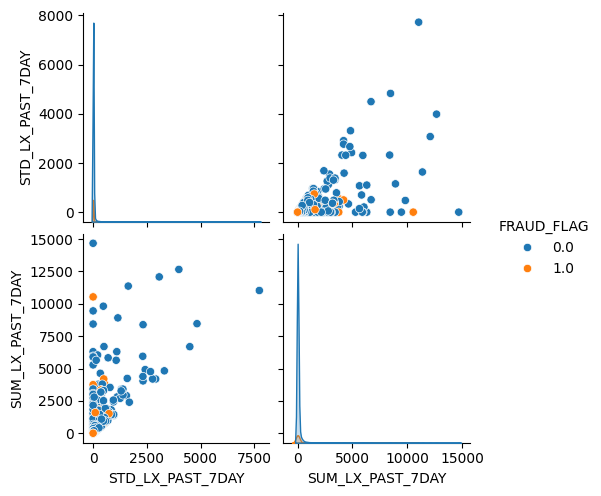

In [ ]:
sns.pairplot(data=train_df[lx_columns[1:] + ["FRAUD_FLAG"]], hue="FRAUD_FLAG")
plt.show()

In [ ]:
train_df["FLAG_LX"] = train_df["FLAG_LX"].astype("category")
test_df["FLAG_LX"] = test_df["FLAG_LX"].astype("category")

### atm_columns

In [ ]:
print(atm_columns)

['FLAG_ATM']


In [ ]:
train_df["FLAG_ATM"].value_counts()

0    11903
Name: FLAG_ATM, dtype: int64

it's just one variable with one unique value. We'll drop it!

In [ ]:
train_df.drop(atm_columns, axis=1, inplace=True)
test_df.drop(atm_columns, axis=1, inplace=True)

### auto_columns

In [ ]:
auto_columns

['FLAG_AUTO',
 'MEAN_AUTO_PAST_7DAY',
 'SUM_AUTO_PAST_7DAY',
 'COUNT_AUTO_PAST_7DAY',
 'MEAN_AUTO_PAST_30DAY',
 'MAX_AUTO_PAST_30DAY',
 'STD_AUTO_PAST_30DAY',
 'SUM_AUTO_PAST_30DAY',
 'COUNT_AUTO_PAST_30DAY']

In [ ]:
train_df[auto_columns[1:]].corr()

,MEAN_AUTO_PAST_7DAY,SUM_AUTO_PAST_7DAY,COUNT_AUTO_PAST_7DAY,MEAN_AUTO_PAST_30DAY,MAX_AUTO_PAST_30DAY,STD_AUTO_PAST_30DAY,SUM_AUTO_PAST_30DAY,COUNT_AUTO_PAST_30DAY
MEAN_AUTO_PAST_7DAY,1.000000,0.860728,0.113075,0.474579,0.532285,0.483119,0.353669,0.086942
SUM_AUTO_PAST_7DAY,0.860728,1.000000,0.374537,0.434663,0.521815,0.453042,0.593522,0.319296
COUNT_AUTO_PAST_7DAY,0.113075,0.374537,1.000000,0.073776,0.162651,0.117359,0.437177,0.816895
MEAN_AUTO_PAST_30DAY,0.474579,0.434663,0.073776,1.000000,0.802567,0.499249,0.510702,0.090872
MAX_AUTO_PAST_30DAY,0.532285,0.521815,0.162651,0.802567,1.000000,0.836115,0.705980,0.224549
STD_AUTO_PAST_30DAY,0.483119,0.453042,0.117359,0.499249,0.836115,1.000000,0.566257,0.169473
SUM_AUTO_PAST_30DAY,0.353669,0.593522,0.437177,0.510702,0.705980,0.566257,1.000000,0.548303
COUNT_AUTO_PAST_30DAY,0.086942,0.319296,0.816895,0.090872,0.224549,0.169473,0.548303,1.000000


due to the high correlation, We'll drop the following: "SUM_AUTO_PAST_7DAY" , "COUNT_AUTO_PAST_30DAY", "MAX_AUTO_PAST_30DAY"

In [ ]:
train_df.drop(["SUM_AUTO_PAST_7DAY" , "COUNT_AUTO_PAST_30DAY", "MAX_AUTO_PAST_30DAY"], axis=1, inplace=True)
test_df.drop(["SUM_AUTO_PAST_7DAY" , "COUNT_AUTO_PAST_30DAY", "MAX_AUTO_PAST_30DAY"], axis=1, inplace=True)

We'll create and new column list for auto:

In [ ]:
auto_columns_new = [col for col in auto_columns if col not in ["SUM_AUTO_PAST_7DAY" , "COUNT_AUTO_PAST_30DAY",
                                                               "MAX_AUTO_PAST_30DAY"]]

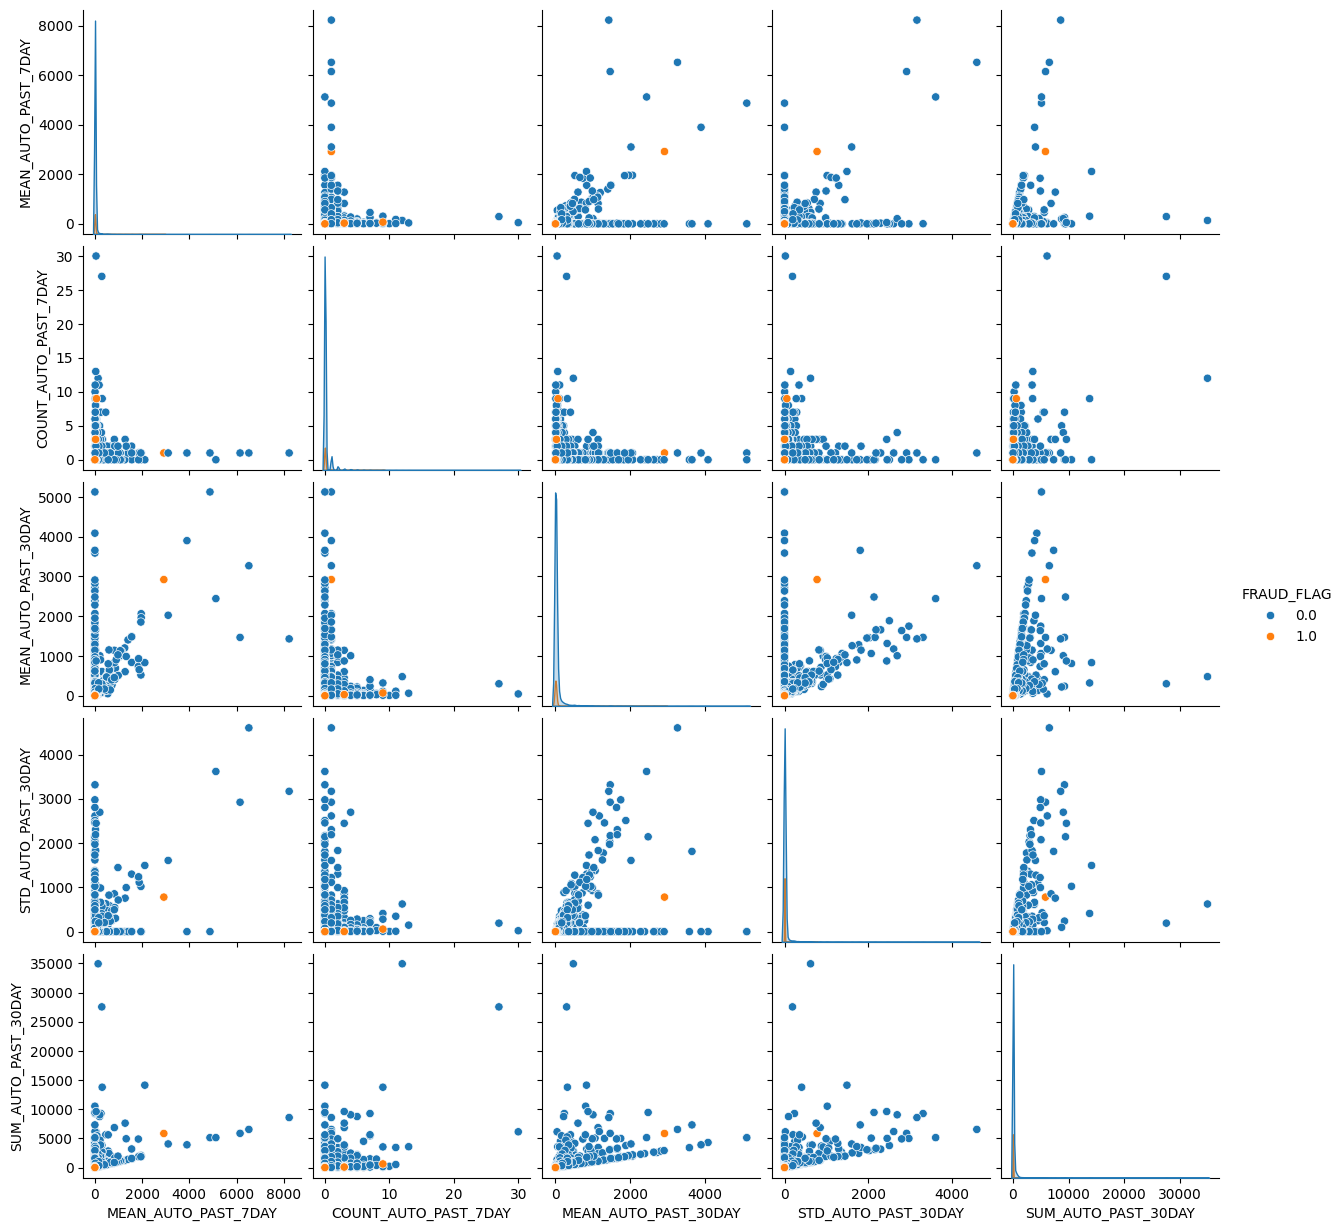

In [ ]:
sns.pairplot(data=train_df[auto_columns_new[1:]+["FRAUD_FLAG"]], hue="FRAUD_FLAG")
plt.show()

In [ ]:
auto_columns_new[1:]

['MEAN_AUTO_PAST_7DAY',
 'COUNT_AUTO_PAST_7DAY',
 'MEAN_AUTO_PAST_30DAY',
 'STD_AUTO_PAST_30DAY',
 'SUM_AUTO_PAST_30DAY']

In [ ]:
train_df["auto_mean_ratio"] = train_df["MEAN_AUTO_PAST_7DAY"] / train_df["MEAN_AUTO_PAST_30DAY"]
train_df["auto_mean_ratio"] = train_df["auto_mean_ratio"].fillna(0)

train_df["auto_sum_ratio"] = (train_df["MEAN_AUTO_PAST_7DAY"] * train_df["COUNT_AUTO_PAST_7DAY"]) / train_df["SUM_AUTO_PAST_30DAY"]
train_df["auto_sum_ratio"] = train_df["auto_sum_ratio"].fillna(0)


test_df["auto_mean_ratio"] = test_df["MEAN_AUTO_PAST_7DAY"] / test_df["MEAN_AUTO_PAST_30DAY"]
test_df["auto_mean_ratio"] = test_df["auto_mean_ratio"].fillna(0)

test_df["auto_sum_ratio"] = (test_df["MEAN_AUTO_PAST_7DAY"] * test_df["COUNT_AUTO_PAST_7DAY"]) / test_df["SUM_AUTO_PAST_30DAY"]
test_df["auto_sum_ratio"] = test_df["auto_sum_ratio"].fillna(0)

In [ ]:
new_auto_ratio_vars = ["auto_mean_ratio", "auto_sum_ratio"]

The priority will be given to the new "ratio" columns, as we believe that they contain more information.

In [ ]:
train_df[auto_columns_new[1:] + new_auto_ratio_vars].corr()

,MEAN_AUTO_PAST_7DAY,COUNT_AUTO_PAST_7DAY,MEAN_AUTO_PAST_30DAY,STD_AUTO_PAST_30DAY,SUM_AUTO_PAST_30DAY,auto_mean_ratio,auto_sum_ratio
MEAN_AUTO_PAST_7DAY,1.000000,0.113075,0.474579,0.483119,0.353669,0.380819,0.258657
COUNT_AUTO_PAST_7DAY,0.113075,1.000000,0.073776,0.117359,0.437177,0.450835,0.500105
MEAN_AUTO_PAST_30DAY,0.474579,0.073776,1.000000,0.499249,0.510702,0.145810,0.133805
STD_AUTO_PAST_30DAY,0.483119,0.117359,0.499249,1.000000,0.566257,0.178383,0.098288
SUM_AUTO_PAST_30DAY,0.353669,0.437177,0.510702,0.566257,1.000000,0.186552,0.103992
auto_mean_ratio,0.380819,0.450835,0.145810,0.178383,0.186552,1.000000,0.655148
auto_sum_ratio,0.258657,0.500105,0.133805,0.098288,0.103992,0.655148,1.000000


In [ ]:
train_df["FLAG_AUTO"] = train_df["FLAG_AUTO"].astype("category")
test_df["FLAG_AUTO"] = test_df["FLAG_AUTO"].astype("category")

### cash_columns


In [ ]:
cash_columns

['FLAG_CASH', 'MAX_CASH_PAST_7DAY']

In [ ]:
train_df["FLAG_CASH"].value_counts()

0    11903
Name: FLAG_CASH, dtype: int64

In [ ]:
print("number of the MAX_CASH_PAST_7DAY > 0 in non-frauds:", train_df[(train_df["FRAUD_FLAG"] == 0) & (train_df["MAX_CASH_PAST_7DAY"] > 0)]["MAX_CASH_PAST_7DAY"].count())
print("number of the MAX_CASH_PAST_7DAY > 0 in frauds:", train_df[(train_df["FRAUD_FLAG"] == 1) & (train_df["MAX_CASH_PAST_7DAY"] > 0)]["MAX_CASH_PAST_7DAY"].count())

number of the MAX_CASH_PAST_7DAY > 0 in non-frauds: 69
number of the MAX_CASH_PAST_7DAY > 0 in frauds: 1


Let's discuss "MAX_CASH_PAST_7DAY." It seems to consistently show zeros and doesn't engage with frauds – the flag remains stuck at 0 for every entry. Even in cases where there's non-zero activity, it's sparse, with only one fraud case involved out of 70 instances.

Given these statistics, we've decided it's time to bid farewell. These columns aren't contributing significantly to our analysis, so we're decluttering our data – both "MAX_CASH_PAST_7DAY" and its associated flag are gracefully being removed.

In [ ]:
train_df.drop(cash_columns, axis=1, inplace=True)
test_df.drop(cash_columns, axis=1, inplace=True)

### apparel_columns

In [ ]:
print(apparel_columns)
print()
train_df[apparel_columns].corr()

['FLAG_APPAREL', 'MEAN_APPAREL_PAST_7DAY', 'MAX_APPAREL_PAST_7DAY', 'SUM_APPAREL_PAST_7DAY', 'MAX_APPAREL_PAST_30DAY', 'STD_APPAREL_PAST_30DAY', 'SUM_APPAREL_PAST_30DAY']



,FLAG_APPAREL,MEAN_APPAREL_PAST_7DAY,MAX_APPAREL_PAST_7DAY,SUM_APPAREL_PAST_7DAY,MAX_APPAREL_PAST_30DAY,STD_APPAREL_PAST_30DAY,SUM_APPAREL_PAST_30DAY
FLAG_APPAREL,1.000000,0.033105,0.043029,0.058098,0.035883,0.030354,0.063935
MEAN_APPAREL_PAST_7DAY,0.033105,1.000000,0.918603,0.764389,0.632661,0.575136,0.704039
MAX_APPAREL_PAST_7DAY,0.043029,0.918603,1.000000,0.896419,0.689328,0.639097,0.710124
SUM_APPAREL_PAST_7DAY,0.058098,0.764389,0.896419,1.000000,0.627751,0.565576,0.697324
MAX_APPAREL_PAST_30DAY,0.035883,0.632661,0.689328,0.627751,1.000000,0.866794,0.828111
STD_APPAREL_PAST_30DAY,0.030354,0.575136,0.639097,0.565576,0.866794,1.000000,0.770481
SUM_APPAREL_PAST_30DAY,0.063935,0.704039,0.710124,0.697324,0.828111,0.770481,1.000000


In the midst of the crowd, a couple of standout features have captured our attention: 'MEAN_APPAREL_PAST_7DAY' and 'STD_APPAREL_PAST_30DAY'. They're not your average features – they possess that unique quality of low correlation.

In our pursuit of streamlined elegance, we're making a decision. These two gems have earned their place, while the others step aside due to their high correlation.

In [ ]:
apparel_columns_new = ["FLAG_APPAREL", 'MEAN_APPAREL_PAST_7DAY', 'STD_APPAREL_PAST_30DAY']

In [ ]:
cols_to_drop = [col for col in apparel_columns if col not in apparel_columns_new]
print(cols_to_drop)

['MAX_APPAREL_PAST_7DAY', 'SUM_APPAREL_PAST_7DAY', 'MAX_APPAREL_PAST_30DAY', 'SUM_APPAREL_PAST_30DAY']


In [ ]:
train_df.drop(cols_to_drop, inplace=True, axis=1)
test_df.drop(cols_to_drop, inplace=True, axis=1)

In [ ]:
train_df["FLAG_APPAREL"] = train_df["FLAG_APPAREL"].astype("category")
test_df["FLAG_APPAREL"] = test_df["FLAG_APPAREL"].astype("category")

### deal_columns

In [ ]:
deal_columns

['FLAG_DEAL', 'MEAN_DEAL_PAST_30DAY', 'SUM_DEAL_PAST_30DAY']

In [ ]:
train_df[deal_columns[1:]].corr()

,MEAN_DEAL_PAST_30DAY,SUM_DEAL_PAST_30DAY
MEAN_DEAL_PAST_30DAY,1.000000,0.216893
SUM_DEAL_PAST_30DAY,0.216893,1.000000


In [ ]:
train_df["deal_mean30_sum30_ratio"] = train_df["MEAN_DEAL_PAST_30DAY"] / train_df["SUM_DEAL_PAST_30DAY"]
train_df["deal_mean30_sum30_ratio"] = train_df["deal_mean30_sum30_ratio"].fillna(0)

test_df["deal_mean30_sum30_ratio"] = test_df["MEAN_DEAL_PAST_30DAY"] / test_df["SUM_DEAL_PAST_30DAY"]
test_df["deal_mean30_sum30_ratio"] = test_df["deal_mean30_sum30_ratio"].fillna(0)

In [ ]:
new_deal_ratio_vars = ["deal_mean30_sum30_ratio"]

In [ ]:
train_df[deal_columns[1:] + new_deal_ratio_vars].corr()

,MEAN_DEAL_PAST_30DAY,SUM_DEAL_PAST_30DAY,deal_mean30_sum30_ratio
MEAN_DEAL_PAST_30DAY,1.000000,0.216893,0.438983
SUM_DEAL_PAST_30DAY,0.216893,1.000000,0.055955
deal_mean30_sum30_ratio,0.438983,0.055955,1.000000


In [ ]:
train_df["FLAG_DEAL"] = train_df["FLAG_DEAL"].astype("category")
test_df["FLAG_DEAL"] = test_df["FLAG_DEAL"].astype("category")

### entertainment_columns

In [ ]:
entertainment_columns

['FLAG_ENTERTAINMENT',
 'COUNT_ENTERTAINMENT_PAST_7DAY',
 'MEAN_ENTERTAINMENT_PAST_30DAY',
 'MAX_ENTERTAINMENT_PAST_30DAY',
 'STD_ENTERTAINMENT_PAST_30DAY',
 'SUM_ENTERTAINMENT_PAST_30DAY']

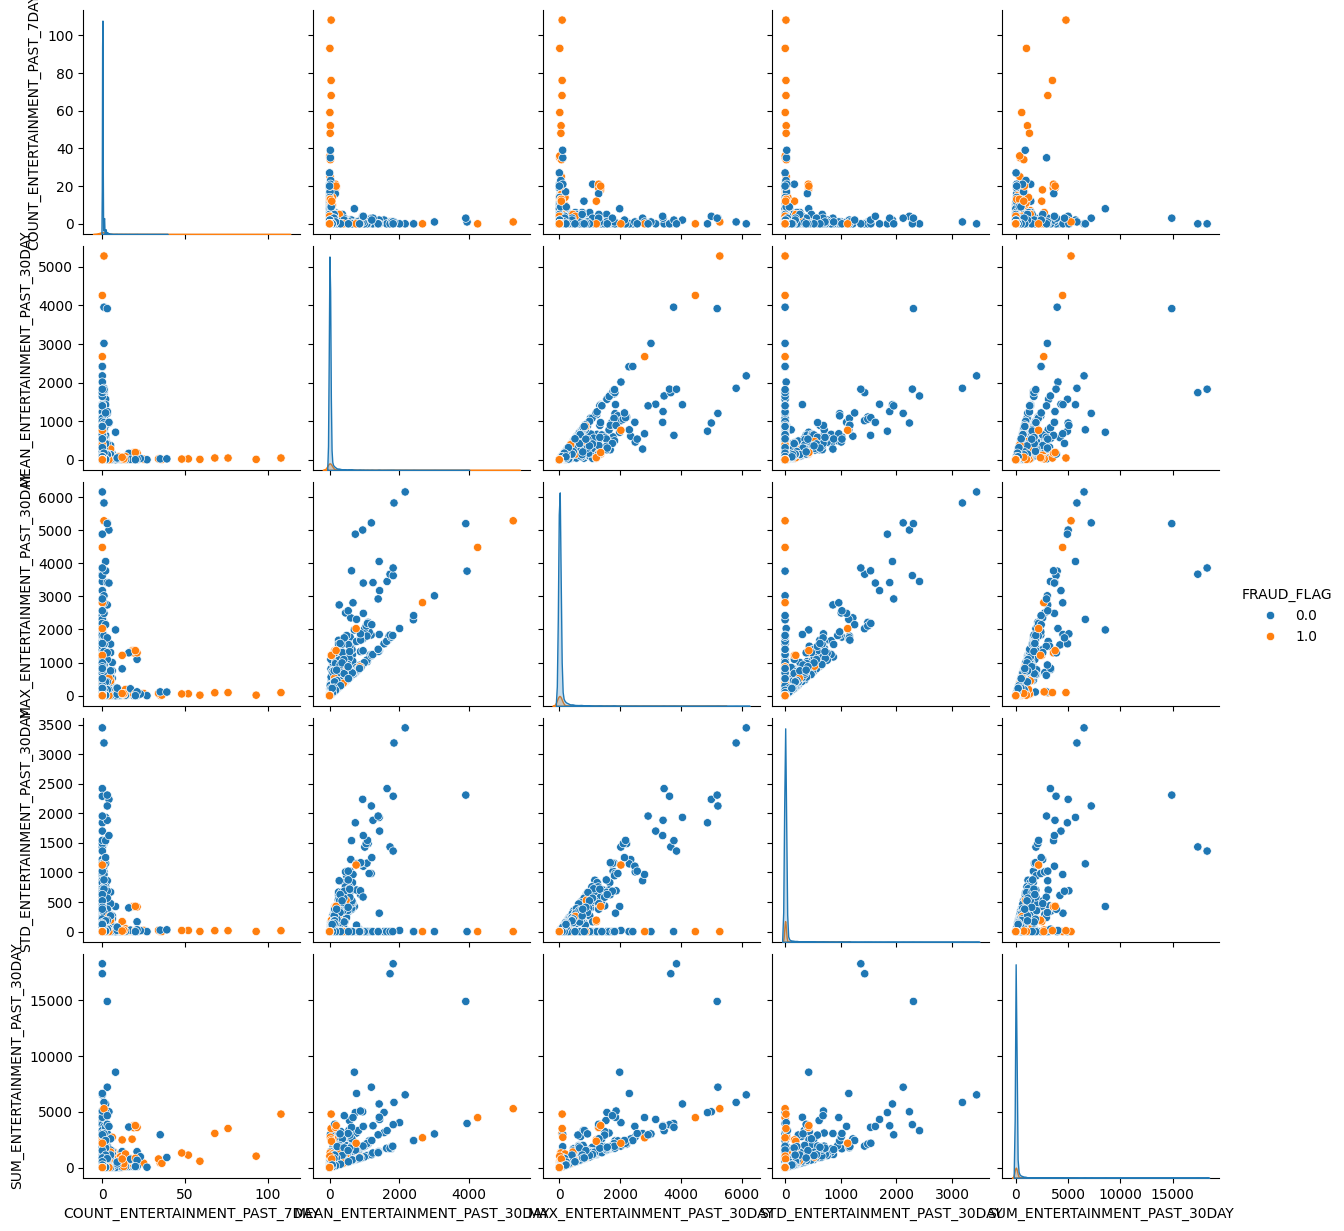

In [ ]:
sns.pairplot(train_df[entertainment_columns[1:] + ["FRAUD_FLAG"]], hue="FRAUD_FLAG")
plt.show()

In [ ]:
train_df[entertainment_columns[1:]].corr()

,COUNT_ENTERTAINMENT_PAST_7DAY,MEAN_ENTERTAINMENT_PAST_30DAY,MAX_ENTERTAINMENT_PAST_30DAY,STD_ENTERTAINMENT_PAST_30DAY,SUM_ENTERTAINMENT_PAST_30DAY
COUNT_ENTERTAINMENT_PAST_7DAY,1.000000,0.030899,0.077558,0.060046,0.225213
MEAN_ENTERTAINMENT_PAST_30DAY,0.030899,1.000000,0.856933,0.518614,0.699636
MAX_ENTERTAINMENT_PAST_30DAY,0.077558,0.856933,1.000000,0.836937,0.837020
STD_ENTERTAINMENT_PAST_30DAY,0.060046,0.518614,0.836937,1.000000,0.703245
SUM_ENTERTAINMENT_PAST_30DAY,0.225213,0.699636,0.837020,0.703245,1.000000


In [ ]:
train_df.drop(["MAX_ENTERTAINMENT_PAST_30DAY", "SUM_ENTERTAINMENT_PAST_30DAY"], axis=1, inplace=True)
test_df.drop(["MAX_ENTERTAINMENT_PAST_30DAY", "SUM_ENTERTAINMENT_PAST_30DAY"], axis=1, inplace=True)

In [ ]:
entertainment_columns_new = [col for col in entertainment_columns if col not in ["MAX_ENTERTAINMENT_PAST_30DAY", "SUM_ENTERTAINMENT_PAST_30DAY"]]

In [ ]:
train_df["FLAG_ENTERTAINMENT"] = train_df["FLAG_ENTERTAINMENT"].astype("category")
test_df["FLAG_ENTERTAINMENT"] = test_df["FLAG_ENTERTAINMENT"].astype("category")

### gift_card_columns

In [ ]:
train_df[gift_card_columns[1:]].corr()

,MEAN_GIFT_CARD_PAST_7DAY,MEAN_GIFT_CARD_PAST_30DAY,STD_GIFT_CARD_PAST_30DAY,SUM_GIFT_CARD_PAST_30DAY,COUNT_GIFT_CARD_PAST_30DAY
MEAN_GIFT_CARD_PAST_7DAY,1.000000,0.662788,0.503649,0.701599,0.128357
MEAN_GIFT_CARD_PAST_30DAY,0.662788,1.000000,0.621218,0.737703,0.113953
STD_GIFT_CARD_PAST_30DAY,0.503649,0.621218,1.000000,0.518261,0.215311
SUM_GIFT_CARD_PAST_30DAY,0.701599,0.737703,0.518261,1.000000,0.189074
COUNT_GIFT_CARD_PAST_30DAY,0.128357,0.113953,0.215311,0.189074,1.000000


In [ ]:
gift_card_columns_new = [col for col in gift_card_columns if col not in ["SUM_GIFT_CARD_PAST_30DAY"]]

In [ ]:
train_df[gift_card_columns_new[1:]].corr()

,MEAN_GIFT_CARD_PAST_7DAY,MEAN_GIFT_CARD_PAST_30DAY,STD_GIFT_CARD_PAST_30DAY,COUNT_GIFT_CARD_PAST_30DAY
MEAN_GIFT_CARD_PAST_7DAY,1.000000,0.662788,0.503649,0.128357
MEAN_GIFT_CARD_PAST_30DAY,0.662788,1.000000,0.621218,0.113953
STD_GIFT_CARD_PAST_30DAY,0.503649,0.621218,1.000000,0.215311
COUNT_GIFT_CARD_PAST_30DAY,0.128357,0.113953,0.215311,1.000000


In [ ]:
train_df["gift_card_mean7_mean30_ratio"] = train_df["MEAN_GIFT_CARD_PAST_7DAY"] / train_df["MEAN_GIFT_CARD_PAST_30DAY"]
train_df["gift_card_mean7_mean30_ratio"] = train_df["gift_card_mean7_mean30_ratio"].fillna(0)

test_df["gift_card_mean7_mean30_ratio"] = test_df["MEAN_GIFT_CARD_PAST_7DAY"] / test_df["MEAN_GIFT_CARD_PAST_30DAY"]
test_df["gift_card_mean7_mean30_ratio"] = test_df["gift_card_mean7_mean30_ratio"].fillna(0)

In [ ]:
train_df[gift_card_columns_new + ["gift_card_mean7_mean30_ratio"]].corr()

,FLAG_GIFT_CARD,MEAN_GIFT_CARD_PAST_7DAY,MEAN_GIFT_CARD_PAST_30DAY,STD_GIFT_CARD_PAST_30DAY,COUNT_GIFT_CARD_PAST_30DAY,gift_card_mean7_mean30_ratio
FLAG_GIFT_CARD,1.000000,0.024110,0.001060,-0.002401,0.023081,0.035505
MEAN_GIFT_CARD_PAST_7DAY,0.024110,1.000000,0.662788,0.503649,0.128357,0.369614
MEAN_GIFT_CARD_PAST_30DAY,0.001060,0.662788,1.000000,0.621218,0.113953,0.099558
STD_GIFT_CARD_PAST_30DAY,-0.002401,0.503649,0.621218,1.000000,0.215311,0.154989
COUNT_GIFT_CARD_PAST_30DAY,0.023081,0.128357,0.113953,0.215311,1.000000,0.386605
gift_card_mean7_mean30_ratio,0.035505,0.369614,0.099558,0.154989,0.386605,1.000000


In [ ]:
new_gift_card_ratio_vars = ["gift_card_mean7_mean30_ratio"]

In [ ]:
train_df[gift_card_columns_new[1:] + new_gift_card_ratio_vars].corr()

,MEAN_GIFT_CARD_PAST_7DAY,MEAN_GIFT_CARD_PAST_30DAY,STD_GIFT_CARD_PAST_30DAY,COUNT_GIFT_CARD_PAST_30DAY,gift_card_mean7_mean30_ratio
MEAN_GIFT_CARD_PAST_7DAY,1.000000,0.662788,0.503649,0.128357,0.369614
MEAN_GIFT_CARD_PAST_30DAY,0.662788,1.000000,0.621218,0.113953,0.099558
STD_GIFT_CARD_PAST_30DAY,0.503649,0.621218,1.000000,0.215311,0.154989
COUNT_GIFT_CARD_PAST_30DAY,0.128357,0.113953,0.215311,1.000000,0.386605
gift_card_mean7_mean30_ratio,0.369614,0.099558,0.154989,0.386605,1.000000


In [ ]:
train_df["FLAG_GIFT_CARD"] = train_df["FLAG_GIFT_CARD"].astype("category")
test_df["FLAG_GIFT_CARD"] = test_df["FLAG_GIFT_CARD"].astype("category")

### fastfood_columns

In [ ]:
train_df[fastfood_columns[1:]].corr()

,MEAN_FASTFOOD_PAST_7DAY,STD_FASTFOOD_PAST_7DAY,MAX_FASTFOOD_PAST_30DAY,SUM_FASTFOOD_PAST_30DAY,COUNT_FASTFOOD_PAST_30DAY
MEAN_FASTFOOD_PAST_7DAY,1.000000,0.337194,0.326603,0.395800,0.224918
STD_FASTFOOD_PAST_7DAY,0.337194,1.000000,0.151164,0.357798,0.378639
MAX_FASTFOOD_PAST_30DAY,0.326603,0.151164,1.000000,0.810057,0.160781
SUM_FASTFOOD_PAST_30DAY,0.395800,0.357798,0.810057,1.000000,0.641419
COUNT_FASTFOOD_PAST_30DAY,0.224918,0.378639,0.160781,0.641419,1.000000


In [ ]:
fastfood_columns_new = [col for col in fastfood_columns if col != "MAX_FASTFOOD_PAST_30DAY"]
fastfood_columns_new

['FLAG_FASTFOOD',
 'MEAN_FASTFOOD_PAST_7DAY',
 'STD_FASTFOOD_PAST_7DAY',
 'SUM_FASTFOOD_PAST_30DAY',
 'COUNT_FASTFOOD_PAST_30DAY']

In [ ]:
train_df["fastfood_sum30_count30"] = train_df["SUM_FASTFOOD_PAST_30DAY"] * train_df["COUNT_FASTFOOD_PAST_30DAY"]

test_df["fastfood_sum30_count30"] = test_df["SUM_FASTFOOD_PAST_30DAY"] * test_df["COUNT_FASTFOOD_PAST_30DAY"]

In [ ]:
new_fastfood_ratio_vars = ["fastfood_sum30_count30"]

In [ ]:
train_df[fastfood_columns_new[1:] + new_fastfood_ratio_vars].corr()

,MEAN_FASTFOOD_PAST_7DAY,STD_FASTFOOD_PAST_7DAY,SUM_FASTFOOD_PAST_30DAY,COUNT_FASTFOOD_PAST_30DAY,fastfood_sum30_count30
MEAN_FASTFOOD_PAST_7DAY,1.000000,0.337194,0.395800,0.224918,0.163686
STD_FASTFOOD_PAST_7DAY,0.337194,1.000000,0.357798,0.378639,0.300432
SUM_FASTFOOD_PAST_30DAY,0.395800,0.357798,1.000000,0.641419,0.647314
COUNT_FASTFOOD_PAST_30DAY,0.224918,0.378639,0.641419,1.000000,0.840793
fastfood_sum30_count30,0.163686,0.300432,0.647314,0.840793,1.000000


the new ratio column has a strong correlation with the other columns. so, we drop it!

In [ ]:
train_df.drop("fastfood_sum30_count30", axis=1, inplace=True)

test_df.drop("fastfood_sum30_count30", axis=1, inplace=True)

In [ ]:
train_df["FLAG_FASTFOOD"] = train_df["FLAG_FASTFOOD"].astype("category")

test_df["FLAG_FASTFOOD"] = test_df["FLAG_FASTFOOD"].astype("category")

### gas_columns

In [ ]:
train_df[gas_columns[1:]].corr()

,SUM_GAS_PAST_7DAY,COUNT_GAS_PAST_7DAY,SUM_GAS_PAST_30DAY,COUNT_GAS_PAST_30DAY
SUM_GAS_PAST_7DAY,1.000000,0.307289,0.718678,0.239211
COUNT_GAS_PAST_7DAY,0.307289,1.000000,0.389894,0.778773
SUM_GAS_PAST_30DAY,0.718678,0.389894,1.000000,0.481938
COUNT_GAS_PAST_30DAY,0.239211,0.778773,0.481938,1.000000


In [ ]:
train_df["gas_sum7_count7_ratio"] = train_df["SUM_GAS_PAST_7DAY"] * train_df["COUNT_GAS_PAST_7DAY"]
train_df["gas_sum30_count30_ratio"] = train_df["SUM_GAS_PAST_30DAY"] * train_df["COUNT_GAS_PAST_30DAY"]

test_df["gas_sum7_count7_ratio"] = test_df["SUM_GAS_PAST_7DAY"] * test_df["COUNT_GAS_PAST_7DAY"]
test_df["gas_sum30_count30_ratio"] = test_df["SUM_GAS_PAST_30DAY"] * test_df["COUNT_GAS_PAST_30DAY"]

Exciting developments from the gas category! We've been hard at work combining columns and producing two brand new ratios. It feels like we've unleashed some data magic.

Now, it's time for a little tidying up. With these fantastic new ratios taking the spotlight, we're embracing efficiency and bidding farewell to the original columns.

In [ ]:
train_df.drop(gas_columns[1:], inplace=True, axis=1)
test_df.drop(gas_columns[1:], inplace=True, axis=1)

In [ ]:
gas_columns_new = ["FLAG_GAS", "gas_sum7_count7_ratio", "gas_sum30_count30_ratio"]

In [ ]:
train_df[gas_columns_new[1:]].corr()

,gas_sum7_count7_ratio,gas_sum30_count30_ratio
gas_sum7_count7_ratio,1.000000,0.501436
gas_sum30_count30_ratio,0.501436,1.000000


In [ ]:
train_df["FLAG_GAS"] = train_df["FLAG_GAS"].astype("category")
test_df["FLAG_GAS"] = test_df["FLAG_GAS"].astype("category")

### high_amt_columns

In [ ]:
train_df[high_amt_columns[1:]].corr()

,MEAN_HIGH_AMT_PAST_7DAY,MAX_HIGH_AMT_PAST_7DAY,STD_HIGH_AMT_PAST_7DAY,SUM_HIGH_AMT_PAST_7DAY,COUNT_HIGH_AMT_PAST_7DAY,MEAN_HIGH_AMT_PAST_30DAY,SUM_HIGH_AMT_PAST_30DAY,COUNT_HIGH_AMT_PAST_30DAY
MEAN_HIGH_AMT_PAST_7DAY,1.000000,0.876969,0.528269,0.649841,0.224145,0.690431,0.521120,0.219261
MAX_HIGH_AMT_PAST_7DAY,0.876969,1.000000,0.821384,0.735357,0.371517,0.602350,0.566699,0.327986
STD_HIGH_AMT_PAST_7DAY,0.528269,0.821384,1.000000,0.619757,0.318538,0.360800,0.446774,0.278597
SUM_HIGH_AMT_PAST_7DAY,0.649841,0.735357,0.619757,1.000000,0.525887,0.541153,0.815442,0.409056
COUNT_HIGH_AMT_PAST_7DAY,0.224145,0.371517,0.318538,0.525887,1.000000,0.172132,0.506533,0.743732
MEAN_HIGH_AMT_PAST_30DAY,0.690431,0.602350,0.360800,0.541153,0.172132,1.000000,0.606476,0.210460
SUM_HIGH_AMT_PAST_30DAY,0.521120,0.566699,0.446774,0.815442,0.506533,0.606476,1.000000,0.643590
COUNT_HIGH_AMT_PAST_30DAY,0.219261,0.327986,0.278597,0.409056,0.743732,0.210460,0.643590,1.000000


In [ ]:
train_df["high_amt_sum30_count30_ratio"] = train_df["SUM_HIGH_AMT_PAST_30DAY"] * train_df["COUNT_HIGH_AMT_PAST_30DAY"]
train_df.drop(["SUM_HIGH_AMT_PAST_30DAY", "COUNT_HIGH_AMT_PAST_30DAY"], inplace=True, axis=1)
train_df.drop(["MAX_HIGH_AMT_PAST_7DAY", "SUM_HIGH_AMT_PAST_7DAY", "COUNT_HIGH_AMT_PAST_7DAY"], inplace=True, axis=1)

test_df["high_amt_sum30_count30_ratio"] = test_df["SUM_HIGH_AMT_PAST_30DAY"] * test_df["COUNT_HIGH_AMT_PAST_30DAY"]
test_df.drop(["SUM_HIGH_AMT_PAST_30DAY", "COUNT_HIGH_AMT_PAST_30DAY"], inplace=True, axis=1)
test_df.drop(["MAX_HIGH_AMT_PAST_7DAY", "SUM_HIGH_AMT_PAST_7DAY", "COUNT_HIGH_AMT_PAST_7DAY"], inplace=True, axis=1)

In [ ]:
high_amt_columns_new = ["FLAG_HIGH_AMT", "MEAN_HIGH_AMT_PAST_7DAY", "STD_HIGH_AMT_PAST_7DAY", "high_amt_sum30_count30_ratio"]

In [ ]:
train_df[high_amt_columns_new[1:]].corr()

,MEAN_HIGH_AMT_PAST_7DAY,STD_HIGH_AMT_PAST_7DAY,high_amt_sum30_count30_ratio
MEAN_HIGH_AMT_PAST_7DAY,1.000000,0.528269,0.136656
STD_HIGH_AMT_PAST_7DAY,0.528269,1.000000,0.131995
high_amt_sum30_count30_ratio,0.136656,0.131995,1.000000


In [ ]:
train_df["FLAG_HIGH_AMT"] = train_df["FLAG_HIGH_AMT"].astype("category")

test_df["FLAG_HIGH_AMT"] = test_df["FLAG_HIGH_AMT"].astype("category")

### high_recrea_columns

In [ ]:
train_df[high_recrea_columns[1:]].corr()

,MEAN_HIGH_RECREA_PAST_7DAY,MAX_HIGH_RECREA_PAST_7DAY,MAX_HIGH_RECREA_PAST_30DAY,STD_HIGH_RECREA_PAST_30DAY,SUM_HIGH_RECREA_PAST_30DAY
MEAN_HIGH_RECREA_PAST_7DAY,1.000000,0.899107,0.545414,0.416570,0.707569
MAX_HIGH_RECREA_PAST_7DAY,0.899107,1.000000,0.614876,0.504730,0.665403
MAX_HIGH_RECREA_PAST_30DAY,0.545414,0.614876,1.000000,0.903442,0.656770
STD_HIGH_RECREA_PAST_30DAY,0.416570,0.504730,0.903442,1.000000,0.490235
SUM_HIGH_RECREA_PAST_30DAY,0.707569,0.665403,0.656770,0.490235,1.000000


In [ ]:
high_recrea_columns_new = [col for col in high_recrea_columns if col not in ["MEAN_HIGH_RECREA_PAST_7DAY", "MAX_HIGH_RECREA_PAST_30DAY"]]

In [ ]:
train_df.drop( ["MEAN_HIGH_RECREA_PAST_7DAY", "MAX_HIGH_RECREA_PAST_30DAY"], axis=1, inplace=True)

test_df.drop( ["MEAN_HIGH_RECREA_PAST_7DAY", "MAX_HIGH_RECREA_PAST_30DAY"], axis=1, inplace=True)

In [ ]:
train_df["FLAG_HIGH_RECREA"] = train_df["FLAG_HIGH_RECREA"].astype("category")

test_df["FLAG_HIGH_RECREA"] = test_df["FLAG_HIGH_RECREA"].astype("category")

### recrea_columns

In [ ]:
train_df[recrea_columns[1:]].corr()

,MEAN_RECREA_PAST_7DAY,MAX_RECREA_PAST_7DAY,SUM_RECREA_PAST_7DAY,MEAN_RECREA_PAST_30DAY,STD_RECREA_PAST_30DAY,SUM_RECREA_PAST_30DAY,COUNT_RECREA_PAST_30DAY
MEAN_RECREA_PAST_7DAY,1.000000,0.806683,0.649087,0.776924,0.534808,0.623791,0.005146
MAX_RECREA_PAST_7DAY,0.806683,1.000000,0.757891,0.598720,0.606768,0.649968,0.114677
SUM_RECREA_PAST_7DAY,0.649087,0.757891,1.000000,0.603102,0.470313,0.845448,0.159868
MEAN_RECREA_PAST_30DAY,0.776924,0.598720,0.603102,1.000000,0.615954,0.683637,-0.011242
STD_RECREA_PAST_30DAY,0.534808,0.606768,0.470313,0.615954,1.000000,0.653939,0.056584
SUM_RECREA_PAST_30DAY,0.623791,0.649968,0.845448,0.683637,0.653939,1.000000,0.290140
COUNT_RECREA_PAST_30DAY,0.005146,0.114677,0.159868,-0.011242,0.056584,0.290140,1.000000


In [ ]:
train_df["recrea_mean30_count_30_ratio"] = train_df["MEAN_RECREA_PAST_30DAY"] * train_df["COUNT_RECREA_PAST_30DAY"]

test_df["recrea_mean30_count_30_ratio"] = test_df["MEAN_RECREA_PAST_30DAY"] * test_df["COUNT_RECREA_PAST_30DAY"]

In [ ]:
train_df.drop(["MAX_RECREA_PAST_7DAY", "SUM_RECREA_PAST_7DAY", "MEAN_RECREA_PAST_30DAY", "SUM_RECREA_PAST_30DAY", "COUNT_RECREA_PAST_30DAY"],
             inplace=True, axis=1)

test_df.drop(["MAX_RECREA_PAST_7DAY", "SUM_RECREA_PAST_7DAY", "MEAN_RECREA_PAST_30DAY", "SUM_RECREA_PAST_30DAY", "COUNT_RECREA_PAST_30DAY"],
             inplace=True, axis=1)

In [ ]:
recrea_columns_new = ["FLAG_RECREA", "MEAN_RECREA_PAST_7DAY", "STD_RECREA_PAST_30DAY", "recrea_mean30_count_30_ratio"]

In [ ]:
train_df[recrea_columns_new[1:]].corr()

,MEAN_RECREA_PAST_7DAY,STD_RECREA_PAST_30DAY,recrea_mean30_count_30_ratio
MEAN_RECREA_PAST_7DAY,1.000000,0.534808,0.594321
STD_RECREA_PAST_30DAY,0.534808,1.000000,0.626945
recrea_mean30_count_30_ratio,0.594321,0.626945,1.000000


In [ ]:
train_df["FLAG_RECREA"] = train_df["FLAG_RECREA"].astype("category")

test_df["FLAG_RECREA"] = test_df["FLAG_RECREA"].astype("category")

### internet_columns

In [ ]:
train_df[internet_columns[1:]].corr()

,MEAN_INTERNET_PAST_7DAY,MAX_INTERNET_PAST_7DAY,STD_INTERNET_PAST_7DAY,SUM_INTERNET_PAST_7DAY,COUNT_INTERNET_PAST_7DAY,MEAN_INTERNET_PAST_30DAY,STD_INTERNET_PAST_30DAY,SUM_INTERNET_PAST_30DAY,COUNT_INTERNET_PAST_30DAY
MEAN_INTERNET_PAST_7DAY,1.000000,0.868836,0.489211,0.600632,0.004356,0.873022,0.602095,0.586736,0.009652
MAX_INTERNET_PAST_7DAY,0.868836,1.000000,0.789314,0.697063,0.103024,0.744604,0.668384,0.617766,0.106127
STD_INTERNET_PAST_7DAY,0.489211,0.789314,1.000000,0.599551,0.046764,0.419192,0.575305,0.486552,0.058030
SUM_INTERNET_PAST_7DAY,0.600632,0.697063,0.599551,1.000000,0.241221,0.609758,0.446231,0.886395,0.199337
COUNT_INTERNET_PAST_7DAY,0.004356,0.103024,0.046764,0.241221,1.000000,-0.007539,0.011414,0.149607,0.683617
MEAN_INTERNET_PAST_30DAY,0.873022,0.744604,0.419192,0.609758,-0.007539,1.000000,0.698736,0.640112,-0.003202
STD_INTERNET_PAST_30DAY,0.602095,0.668384,0.575305,0.446231,0.011414,0.698736,1.000000,0.512679,0.032443
SUM_INTERNET_PAST_30DAY,0.586736,0.617766,0.486552,0.886395,0.149607,0.640112,0.512679,1.000000,0.231766
COUNT_INTERNET_PAST_30DAY,0.009652,0.106127,0.058030,0.199337,0.683617,-0.003202,0.032443,0.231766,1.000000


In [ ]:
internet_columns_new = ["FLAG_INTERNET", "STD_INTERNET_PAST_7DAY", "COUNT_INTERNET_PAST_7DAY",
                        "STD_INTERNET_PAST_30DAY", "SUM_INTERNET_PAST_30DAY"]

In [ ]:
cols_to_drop = [col for col in internet_columns if col not in internet_columns_new]
train_df.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
test_df.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
train_df[internet_columns_new[1:]].corr()

,STD_INTERNET_PAST_7DAY,COUNT_INTERNET_PAST_7DAY,STD_INTERNET_PAST_30DAY,SUM_INTERNET_PAST_30DAY
STD_INTERNET_PAST_7DAY,1.000000,0.046764,0.575305,0.486552
COUNT_INTERNET_PAST_7DAY,0.046764,1.000000,0.011414,0.149607
STD_INTERNET_PAST_30DAY,0.575305,0.011414,1.000000,0.512679
SUM_INTERNET_PAST_30DAY,0.486552,0.149607,0.512679,1.000000


In [ ]:
train_df["FLAG_INTERNET"] = train_df["FLAG_INTERNET"].astype("category")

test_df["FLAG_INTERNET"] = test_df["FLAG_INTERNET"].astype("category")

### international_columns

In [ ]:
train_df[international_columns[1:]].corr()

,MEAN_INTERNATIONAL_PAST_7DAY,SUM_INTERNATIONAL_PAST_7DAY,SUM_INTERNATIONAL_PAST_30DAY
MEAN_INTERNATIONAL_PAST_7DAY,1.000000,0.726548,0.696517
SUM_INTERNATIONAL_PAST_7DAY,0.726548,1.000000,0.792070
SUM_INTERNATIONAL_PAST_30DAY,0.696517,0.792070,1.000000


In [ ]:
international_columns_new = ["FLAG_INTERNATIONAL", "MEAN_INTERNATIONAL_PAST_7DAY"]

In [ ]:
train_df.drop(["SUM_INTERNATIONAL_PAST_7DAY", "SUM_INTERNATIONAL_PAST_30DAY"], axis=1, inplace=True)

test_df.drop(["SUM_INTERNATIONAL_PAST_7DAY", "SUM_INTERNATIONAL_PAST_30DAY"], axis=1, inplace=True)

In [ ]:
train_df["FLAG_INTERNATIONAL"] = train_df["FLAG_INTERNATIONAL"].astype("category")

test_df["FLAG_INTERNATIONAL"] = test_df["FLAG_INTERNATIONAL"].astype("category")

### fashion_columns

In [ ]:
fashion_columns

['FLAG_FASHION', 'MEAN_FASHION_PAST_7DAY']

We'll keep them

### low_amt_columns

In [ ]:
train_df[low_amt_columns[1:]].corr()

,MEAN_LOW_AMT_PAST_7DAY,STD_LOW_AMT_PAST_7DAY,SUM_LOW_AMT_PAST_7DAY,COUNT_LOW_AMT_PAST_7DAY,MEAN_LOW_AMT_PAST_30DAY,STD_LOW_AMT_PAST_30DAY,SUM_LOW_AMT_PAST_30DAY,COUNT_LOW_AMT_PAST_30DAY
MEAN_LOW_AMT_PAST_7DAY,1.000000,0.519595,0.244913,0.135729,0.623999,0.460757,0.238170,0.222706
STD_LOW_AMT_PAST_7DAY,0.519595,1.000000,0.183651,0.153103,0.300891,0.558886,0.194812,0.247017
SUM_LOW_AMT_PAST_7DAY,0.244913,0.183651,1.000000,0.688007,0.178494,0.109671,0.526671,0.493356
COUNT_LOW_AMT_PAST_7DAY,0.135729,0.153103,0.688007,1.000000,0.080262,0.079749,0.369064,0.638112
MEAN_LOW_AMT_PAST_30DAY,0.623999,0.300891,0.178494,0.080262,1.000000,0.505924,0.216128,0.163587
STD_LOW_AMT_PAST_30DAY,0.460757,0.558886,0.109671,0.079749,0.505924,1.000000,0.153951,0.187774
SUM_LOW_AMT_PAST_30DAY,0.238170,0.194812,0.526671,0.369064,0.216128,0.153951,1.000000,0.824924
COUNT_LOW_AMT_PAST_30DAY,0.222706,0.247017,0.493356,0.638112,0.163587,0.187774,0.824924,1.000000


In [ ]:
train_df.drop(["COUNT_LOW_AMT_PAST_7DAY", "COUNT_LOW_AMT_PAST_30DAY"], inplace=True, axis=1)

test_df.drop(["COUNT_LOW_AMT_PAST_7DAY", "COUNT_LOW_AMT_PAST_30DAY"], inplace=True, axis=1)

In [ ]:
low_amt_columns_new = [col for col in low_amt_columns if col not in ["COUNT_LOW_AMT_PAST_7DAY", "COUNT_LOW_AMT_PAST_30DAY"]]

In [ ]:
train_df[low_amt_columns_new[1:]].corr()

,MEAN_LOW_AMT_PAST_7DAY,STD_LOW_AMT_PAST_7DAY,SUM_LOW_AMT_PAST_7DAY,MEAN_LOW_AMT_PAST_30DAY,STD_LOW_AMT_PAST_30DAY,SUM_LOW_AMT_PAST_30DAY
MEAN_LOW_AMT_PAST_7DAY,1.000000,0.519595,0.244913,0.623999,0.460757,0.238170
STD_LOW_AMT_PAST_7DAY,0.519595,1.000000,0.183651,0.300891,0.558886,0.194812
SUM_LOW_AMT_PAST_7DAY,0.244913,0.183651,1.000000,0.178494,0.109671,0.526671
MEAN_LOW_AMT_PAST_30DAY,0.623999,0.300891,0.178494,1.000000,0.505924,0.216128
STD_LOW_AMT_PAST_30DAY,0.460757,0.558886,0.109671,0.505924,1.000000,0.153951
SUM_LOW_AMT_PAST_30DAY,0.238170,0.194812,0.526671,0.216128,0.153951,1.000000


In [ ]:
train_df["FLAG_LOW_AMT"] = train_df["FLAG_LOW_AMT"].astype("category")

test_df["FLAG_LOW_AMT"] = test_df["FLAG_LOW_AMT"].astype("category")

### manual_columns

In [ ]:
train_df[manual_columns[1:]].corr()

,MEAN_MANUAL_ENTRY_PAST_7DAY,SUM_MANUAL_ENTRY_PAST_7DAY,COUNT_MANUAL_ENTRY_PAST_7DAY,MEAN_MANUAL_ENTRY_PAST_30DAY,MAX_MANUAL_ENTRY_PAST_30DAY,STD_MANUAL_ENTRY_PAST_30DAY,SUM_MANUAL_ENTRY_PAST_30DAY,COUNT_MANUAL_ENTRY_PAST_30DAY
MEAN_MANUAL_ENTRY_PAST_7DAY,1.000000,0.805392,0.110513,0.462812,0.471335,0.461603,0.442053,0.095675
SUM_MANUAL_ENTRY_PAST_7DAY,0.805392,1.000000,0.354878,0.392714,0.520691,0.463311,0.616835,0.274084
COUNT_MANUAL_ENTRY_PAST_7DAY,0.110513,0.354878,1.000000,0.060733,0.160039,0.107278,0.357925,0.891434
MEAN_MANUAL_ENTRY_PAST_30DAY,0.462812,0.392714,0.060733,1.000000,0.728862,0.704233,0.568867,0.070761
MAX_MANUAL_ENTRY_PAST_30DAY,0.471335,0.520691,0.160039,0.728862,1.000000,0.932067,0.784692,0.188626
STD_MANUAL_ENTRY_PAST_30DAY,0.461603,0.463311,0.107278,0.704233,0.932067,1.000000,0.698333,0.129698
SUM_MANUAL_ENTRY_PAST_30DAY,0.442053,0.616835,0.357925,0.568867,0.784692,0.698333,1.000000,0.414923
COUNT_MANUAL_ENTRY_PAST_30DAY,0.095675,0.274084,0.891434,0.070761,0.188626,0.129698,0.414923,1.000000


In [ ]:
train_df[["MEAN_MANUAL_ENTRY_PAST_7DAY", "COUNT_MANUAL_ENTRY_PAST_7DAY", "MEAN_MANUAL_ENTRY_PAST_30DAY", "SUM_MANUAL_ENTRY_PAST_30DAY"]].corr()

,MEAN_MANUAL_ENTRY_PAST_7DAY,COUNT_MANUAL_ENTRY_PAST_7DAY,MEAN_MANUAL_ENTRY_PAST_30DAY,SUM_MANUAL_ENTRY_PAST_30DAY
MEAN_MANUAL_ENTRY_PAST_7DAY,1.000000,0.110513,0.462812,0.442053
COUNT_MANUAL_ENTRY_PAST_7DAY,0.110513,1.000000,0.060733,0.357925
MEAN_MANUAL_ENTRY_PAST_30DAY,0.462812,0.060733,1.000000,0.568867
SUM_MANUAL_ENTRY_PAST_30DAY,0.442053,0.357925,0.568867,1.000000


In [ ]:
manual_columns_new = ["FLAG_MANUAL_ENTRY", "MEAN_MANUAL_ENTRY_PAST_7DAY", "COUNT_MANUAL_ENTRY_PAST_7DAY",
                      "MEAN_MANUAL_ENTRY_PAST_30DAY", "SUM_MANUAL_ENTRY_PAST_30DAY"]

In [ ]:
cols_to_drop = [col for col in manual_columns if col not in manual_columns_new]

train_df.drop(cols_to_drop, axis=1, inplace=True)

test_df.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
train_df["FLAG_MANUAL_ENTRY"] = train_df["FLAG_MANUAL_ENTRY"].astype("category")

test_df["FLAG_MANUAL_ENTRY"] = test_df["FLAG_MANUAL_ENTRY"].astype("category")

### elctrncs_columns

In [ ]:
train_df[elctrncs_columns].corr()

,FLAG_ELCTRNCS,MEAN_ELCTRNCS_PAST_7DAY,SUM_ELCTRNCS_PAST_7DAY,MEAN_ELCTRNCS_PAST_30DAY,COUNT_ELCTRNCS_PAST_30DAY
FLAG_ELCTRNCS,1.000000,0.054210,0.059864,0.045125,0.120537
MEAN_ELCTRNCS_PAST_7DAY,0.054210,1.000000,0.743189,0.568539,0.156889
SUM_ELCTRNCS_PAST_7DAY,0.059864,0.743189,1.000000,0.432568,0.338520
MEAN_ELCTRNCS_PAST_30DAY,0.045125,0.568539,0.432568,1.000000,0.129855
COUNT_ELCTRNCS_PAST_30DAY,0.120537,0.156889,0.338520,0.129855,1.000000


In [ ]:
electrncs_columns_new = [col for col in elctrncs_columns if col not in ["SUM_ELCTRNCS_PAST_7DAY"]]

In [ ]:
train_df.drop(["SUM_ELCTRNCS_PAST_7DAY"], inplace=True, axis=1)

test_df.drop(["SUM_ELCTRNCS_PAST_7DAY"], inplace=True, axis=1)

In [ ]:
train_df["FLAG_ELCTRNCS"] = train_df["FLAG_ELCTRNCS"].astype("category")

test_df["FLAG_ELCTRNCS"] = test_df["FLAG_ELCTRNCS"].astype("category")

### swipe_columns

In [ ]:
train_df[swipe_columns[1:]].corr()

,MEAN_SWIPE_PAST_7DAY,MAX_SWIPE_PAST_7DAY,STD_SWIPE_PAST_7DAY,SUM_SWIPE_PAST_7DAY,COUNT_SWIPE_PAST_7DAY,MEAN_SWIPE_PAST_30DAY,STD_SWIPE_PAST_30DAY,SUM_SWIPE_PAST_30DAY,COUNT_SWIPE_PAST_30DAY
MEAN_SWIPE_PAST_7DAY,1.000000,0.670922,0.419254,0.589965,0.049527,0.709483,0.287966,0.297810,0.041037
MAX_SWIPE_PAST_7DAY,0.670922,1.000000,0.857441,0.837007,0.270067,0.394031,0.456273,0.505231,0.232546
STD_SWIPE_PAST_7DAY,0.419254,0.857441,1.000000,0.670395,0.199334,0.158382,0.495142,0.410370,0.175054
SUM_SWIPE_PAST_7DAY,0.589965,0.837007,0.670395,1.000000,0.478359,0.379914,0.385824,0.656518,0.396341
COUNT_SWIPE_PAST_7DAY,0.049527,0.270067,0.199334,0.478359,1.000000,-0.007171,0.139627,0.600693,0.898858
MEAN_SWIPE_PAST_30DAY,0.709483,0.394031,0.158382,0.379914,-0.007171,1.000000,0.377336,0.312596,-0.009600
STD_SWIPE_PAST_30DAY,0.287966,0.456273,0.495142,0.385824,0.139627,0.377336,1.000000,0.638075,0.155080
SUM_SWIPE_PAST_30DAY,0.297810,0.505231,0.410370,0.656518,0.600693,0.312596,0.638075,1.000000,0.665693
COUNT_SWIPE_PAST_30DAY,0.041037,0.232546,0.175054,0.396341,0.898858,-0.009600,0.155080,0.665693,1.000000


In [ ]:
train_df["swipe_sum30_count30_ratio"] = train_df["COUNT_SWIPE_PAST_30DAY"] * train_df["SUM_SWIPE_PAST_30DAY"]

test_df["swipe_sum30_count30_ratio"] = test_df["COUNT_SWIPE_PAST_30DAY"] * test_df["SUM_SWIPE_PAST_30DAY"]

In [ ]:
swipe_columns_new = ["FLAG_SWIPE", "MEAN_SWIPE_PAST_7DAY", "STD_SWIPE_PAST_7DAY", "SUM_SWIPE_PAST_7DAY", "swipe_sum30_count30_ratio"]

In [ ]:
cols_to_drop = [col for col in swipe_columns if col not in swipe_columns_new]

train_df.drop(cols_to_drop, inplace=True, axis=1)

test_df.drop(cols_to_drop, inplace=True, axis=1)

In [ ]:
train_df["FLAG_SWIPE"] = train_df["FLAG_SWIPE"].astype("category")

test_df["FLAG_SWIPE"] = test_df["FLAG_SWIPE"].astype("category")

### health_columns

In [ ]:
train_df[health_columns[1:]].corr()

,MEAN_HEALTH_PAST_7DAY,STD_HEALTH_PAST_7DAY,COUNT_HEALTH_PAST_7DAY,MEAN_HEALTH_PAST_30DAY,STD_HEALTH_PAST_30DAY,COUNT_HEALTH_PAST_30DAY
MEAN_HEALTH_PAST_7DAY,1.000000,0.502130,0.278331,0.500254,0.339962,0.204180
STD_HEALTH_PAST_7DAY,0.502130,1.000000,0.354293,0.265645,0.453918,0.225184
COUNT_HEALTH_PAST_7DAY,0.278331,0.354293,1.000000,0.139649,0.209793,0.614876
MEAN_HEALTH_PAST_30DAY,0.500254,0.265645,0.139649,1.000000,0.531277,0.195382
STD_HEALTH_PAST_30DAY,0.339962,0.453918,0.209793,0.531277,1.000000,0.319663
COUNT_HEALTH_PAST_30DAY,0.204180,0.225184,0.614876,0.195382,0.319663,1.000000


In [ ]:
train_df["health_mean7_count_7_ratio"] = train_df["MEAN_HEALTH_PAST_7DAY"] * train_df["COUNT_HEALTH_PAST_7DAY"]
train_df["health_mean30_count_30_ratio"] = train_df["MEAN_HEALTH_PAST_30DAY"] * train_df["COUNT_HEALTH_PAST_30DAY"]

test_df["health_mean7_count_7_ratio"] = test_df["MEAN_HEALTH_PAST_7DAY"] * test_df["COUNT_HEALTH_PAST_7DAY"]
test_df["health_mean30_count_30_ratio"] = test_df["MEAN_HEALTH_PAST_30DAY"] * test_df["COUNT_HEALTH_PAST_30DAY"]

In [ ]:
health_columns_new = ["FLAG_HEALTH", "STD_HEALTH_PAST_7DAY", "STD_HEALTH_PAST_30DAY", "health_mean7_count_7_ratio", "health_mean30_count_30_ratio"]

In [ ]:
train_df[health_columns_new[1:]].corr()

,STD_HEALTH_PAST_7DAY,STD_HEALTH_PAST_30DAY,health_mean7_count_7_ratio,health_mean30_count_30_ratio
STD_HEALTH_PAST_7DAY,1.000000,0.453918,0.660054,0.348793
STD_HEALTH_PAST_30DAY,0.453918,1.000000,0.347909,0.694585
health_mean7_count_7_ratio,0.660054,0.347909,1.000000,0.520345
health_mean30_count_30_ratio,0.348793,0.694585,0.520345,1.000000


In [ ]:
health_columns_new.remove("STD_HEALTH_PAST_30DAY")

In [ ]:
cols_to_drop = [col for col in health_columns if col not in health_columns_new]

train_df.drop(cols_to_drop, inplace=True, axis=1)

test_df.drop(cols_to_drop, inplace=True, axis=1)

In [ ]:
train_df["FLAG_HEALTH"] = train_df["FLAG_HEALTH"].astype("category")

test_df["FLAG_HEALTH"] = test_df["FLAG_HEALTH"].astype("category")

### weekend_columns

In [ ]:
train_df[weekend_columns].corr()

,MEAN_WEEKEND_PAST_7DAY,MAX_WEEKEND_PAST_7DAY,SUM_WEEKEND_PAST_7DAY,COUNT_WEEKEND_PAST_7DAY,MEAN_WEEKEND_PAST_30DAY,MAX_WEEKEND_PAST_30DAY,SUM_WEEKEND_PAST_30DAY,COUNT_WEEKEND_PAST_30DAY
MEAN_WEEKEND_PAST_7DAY,1.000000,0.844134,0.600518,0.036262,0.407068,0.452013,0.390468,0.045403
MAX_WEEKEND_PAST_7DAY,0.844134,1.000000,0.796300,0.220003,0.305871,0.527158,0.507638,0.201488
SUM_WEEKEND_PAST_7DAY,0.600518,0.796300,1.000000,0.515237,0.219644,0.418387,0.686406,0.336142
COUNT_WEEKEND_PAST_7DAY,0.036262,0.220003,0.515237,1.000000,0.000394,0.131227,0.358855,0.655758
MEAN_WEEKEND_PAST_30DAY,0.407068,0.305871,0.219644,0.000394,1.000000,0.690606,0.457120,-0.000239
MAX_WEEKEND_PAST_30DAY,0.452013,0.527158,0.418387,0.131227,0.690606,1.000000,0.766063,0.197055
SUM_WEEKEND_PAST_30DAY,0.390468,0.507638,0.686406,0.358855,0.457120,0.766063,1.000000,0.453036
COUNT_WEEKEND_PAST_30DAY,0.045403,0.201488,0.336142,0.655758,-0.000239,0.197055,0.453036,1.000000


In [ ]:
weekend_columns_new = ["MEAN_WEEKEND_PAST_7DAY", "SUM_WEEKEND_PAST_7DAY", "COUNT_WEEKEND_PAST_7DAY", "MEAN_WEEKEND_PAST_30DAY",
                       "SUM_WEEKEND_PAST_30DAY", "COUNT_WEEKEND_PAST_30DAY"]

In [ ]:
train_df[weekend_columns_new].corr()

,MEAN_WEEKEND_PAST_7DAY,SUM_WEEKEND_PAST_7DAY,COUNT_WEEKEND_PAST_7DAY,MEAN_WEEKEND_PAST_30DAY,SUM_WEEKEND_PAST_30DAY,COUNT_WEEKEND_PAST_30DAY
MEAN_WEEKEND_PAST_7DAY,1.000000,0.600518,0.036262,0.407068,0.390468,0.045403
SUM_WEEKEND_PAST_7DAY,0.600518,1.000000,0.515237,0.219644,0.686406,0.336142
COUNT_WEEKEND_PAST_7DAY,0.036262,0.515237,1.000000,0.000394,0.358855,0.655758
MEAN_WEEKEND_PAST_30DAY,0.407068,0.219644,0.000394,1.000000,0.457120,-0.000239
SUM_WEEKEND_PAST_30DAY,0.390468,0.686406,0.358855,0.457120,1.000000,0.453036
COUNT_WEEKEND_PAST_30DAY,0.045403,0.336142,0.655758,-0.000239,0.453036,1.000000


In [ ]:
cols_to_drop = [col for col in weekend_columns if col not in weekend_columns_new]

train_df.drop(cols_to_drop, inplace=True, axis=1)

test_df.drop(cols_to_drop, inplace=True, axis=1)

### partial_columns

In [ ]:
train_df[partial_columns].corr()

,SUM_PARTIAL_PAST_7DAY,MAX_PARTIAL_PAST_30DAY,STD_PARTIAL_PAST_30DAY
SUM_PARTIAL_PAST_7DAY,1.000000,0.290655,0.043312
MAX_PARTIAL_PAST_30DAY,0.290655,1.000000,0.512614
STD_PARTIAL_PAST_30DAY,0.043312,0.512614,1.000000


## 4. In-Depth Analysis of Merged Features

### Let's delve into the clickstream: revealing the intrigue within.

Get ready to hold onto your hats – we're stepping into the captivating realm of clickstream data. This is where the excitement ramps up, as we explore the "other_cols" section, where the clickstream dataset truly comes alive.

Picture uncovering the intricate patterns and narratives concealed within clicks, swipes, and taps. From CITY to BROWSER_FAMILY, each entry conceals secrets just waiting to be discovered.

In [ ]:
print(other_cols)

['EVENT_DATETIME', 'FRAUD_FLAG', 'AVAIL_CRDT', 'AMOUNT', 'CREDIT_LIMIT', 'CARD_NOT_PRESENT', 'TIMESTAMP_MIN', 'TIMESTAMP_MAX', 'PAGE_NAME', 'BROWSER_FAMILY', 'OS_FAMILY', 'DEVICE_FAMILY', 'DEVICE_BRAND', 'DEVICE_MODEL', 'CITY', 'TIME_SPENT']


### 'AVAIL_CRDT', 'AMOUNT', 'CREDIT_LIMIT'

In [ ]:
train_df[['AVAIL_CRDT', 'AMOUNT', 'CREDIT_LIMIT']].corr()

,AVAIL_CRDT,AMOUNT,CREDIT_LIMIT
AVAIL_CRDT,1.000000,0.055768,0.840051
AMOUNT,0.055768,1.000000,0.075691
CREDIT_LIMIT,0.840051,0.075691,1.000000


As we navigate through the landscape of credit-related columns, it's decision time. Here's the situation: there's a noticeable correlation between credit limit and available credit. These two features seem to move in harmony.

However, it's time to make a decision, and our intuition is guiding us to drop the credit limit. Why, you might wonder? Well, in the realm of fraudsters, available credit might hold more significance. Therefore, we're allowing the credit limit to gracefully step aside, giving available credit the spotlight it deserves.







In [ ]:
train_df.drop("CREDIT_LIMIT", inplace=True, axis=1)

test_df.drop("CREDIT_LIMIT", inplace=True, axis=1)

In [ ]:
train_df.drop(['CARD_NOT_PRESENT', 'TIMESTAMP_MIN', 'TIMESTAMP_MAX'], inplace=True, axis=1)

test_df.drop(['CARD_NOT_PRESENT', 'TIMESTAMP_MIN', 'TIMESTAMP_MAX'], inplace=True, axis=1)

### Unveiling Time's Secrets: Analyzing EVENT_DATETIME

It's time to shine a spotlight on EVENT_DATETIME – the key to unraveling the captivating interplay between fraud and time. We're ready to roll up our sleeves and craft new features that unveil the enchantment of days, hours, and dates.

Picture this: we're dissecting EVENT_DATETIME to reveal its concealed connections with fraud. From the day of the week to the hour of the day, and even the day of the month – each aspect is stepping into the spotlight for closer examination.

In [ ]:
train_df["EVENT_DATETIME"] = pd.to_datetime(train_df["EVENT_DATETIME"])
train_df["hour_of_day"] = train_df["EVENT_DATETIME"].dt.hour
train_df["day_of_month"] = train_df["EVENT_DATETIME"].dt.day
train_df["day_of_week"] = train_df["EVENT_DATETIME"].dt.dayofweek
train_df.drop("EVENT_DATETIME", axis=1, inplace=True)

test_df["EVENT_DATETIME"] = pd.to_datetime(test_df["EVENT_DATETIME"])
test_df["hour_of_day"] = test_df["EVENT_DATETIME"].dt.hour
test_df["day_of_month"] = test_df["EVENT_DATETIME"].dt.day
test_df["day_of_week"] = test_df["EVENT_DATETIME"].dt.dayofweek
test_df.drop("EVENT_DATETIME", axis=1, inplace=True)

### day of week

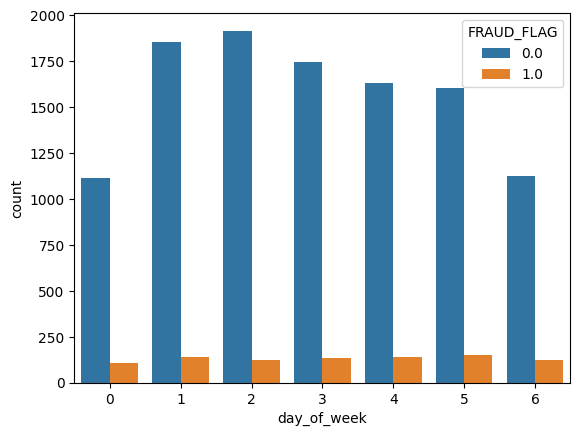

In [ ]:
sns.countplot(data=train_df, x="day_of_week", hue="FRAUD_FLAG")
plt.show()

Our expedition into the realm of time brought us to investigate the fluctuation of fraud and non-fraud occurrences across various days of the week. However, to our surprise, the narrative didn't unfold as anticipated. No discernible patterns surfaced from this investigation. Therefore, we're pivoting our time narrative. We've decided to reimagine the days of the week, categorizing them into weekdays and weekends.

In [ ]:
mapping = {0:0, 1:0, 2:0, 3:0, 4:0, 5:1, 6:1}

train_df["day_of_week_categorized"] = train_df["day_of_week"].map(mapping)

test_df["day_of_week_categorized"] = test_df["day_of_week"].map(mapping)

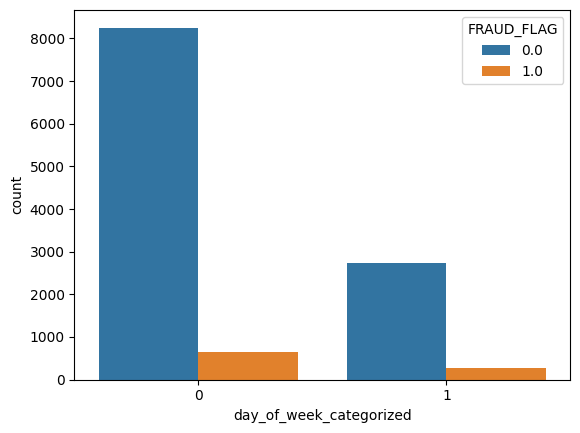

In [ ]:
sns.countplot(data=train_df, x="day_of_week_categorized", hue="FRAUD_FLAG")
plt.show()

In [ ]:
train_df.drop("day_of_week", inplace=True, axis=1)

test_df.drop("day_of_week", inplace=True, axis=1)

In [ ]:
train_df["day_of_week_categorized"] = train_df["day_of_week_categorized"].astype("category")

test_df["day_of_week_categorized"] = test_df["day_of_week_categorized"].astype("category")

### hour of day

As we journeyed through the cycles of the clock, we meticulously examined fraud occurrences across different hours of the day. Although a subtle pattern emerged in the data, we found ourselves at a crossroads: should we venture down the path of one-hot encoding, rich with possibilities but burdened by complexity, or opt for a simpler route?

In a surprising turn, we've opted for simplicity without sacrificing insight. By grouping hours into three eight-hour categories, we've created a new variable that hints at tales of fraud activity. The key lies in the spotlight shining on hours 8 to 15, where the rhythm of fraudulent activity resonates more strongly compared to other time intervals.

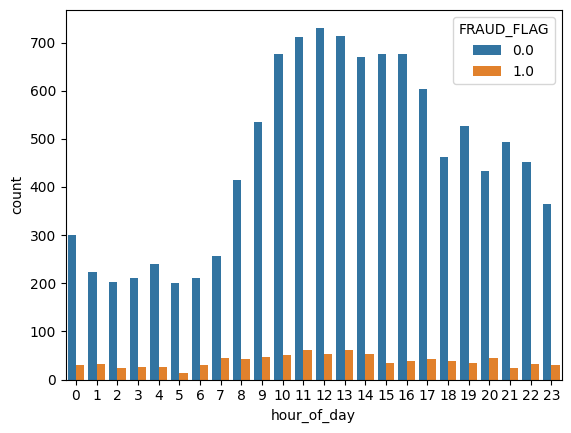

In [ ]:
sns.countplot(data=train_df, x="hour_of_day", hue="FRAUD_FLAG")
plt.show()

categorizing the hour of the day to 3 eight-hour categories

In [ ]:
train_df["hour_of_day_categorized"] = train_df["hour_of_day"].apply(lambda x: 0 if 0 <= x <= 7 else 1 if 7 < x <= 15 else 2)

test_df["hour_of_day_categorized"] = test_df["hour_of_day"].apply(lambda x: 0 if 0 <= x <= 7 else 1 if 7 < x <= 15 else 2)

In [ ]:
train_df["hour_of_day_categorized"].value_counts(normalize=True)

1    0.464757
2    0.361001
0    0.174242
Name: hour_of_day_categorized, dtype: float64

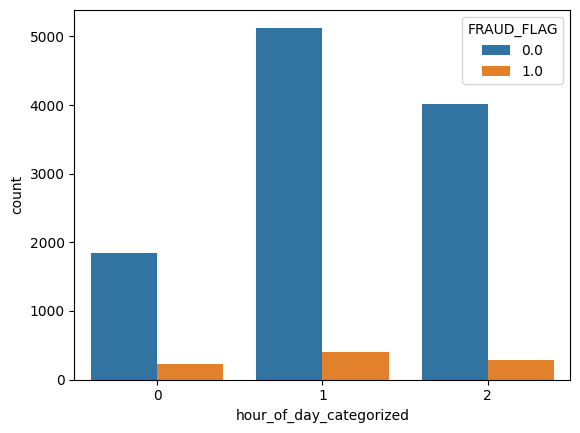

In [ ]:
sns.countplot(data=train_df, x="hour_of_day_categorized", hue="FRAUD_FLAG")
plt.show()

In [ ]:
train_df[train_df["FRAUD_FLAG"] == 1]["hour_of_day_categorized"].value_counts(normalize=True)

1    0.438998
2    0.312636
0    0.248366
Name: hour_of_day_categorized, dtype: float64

In [ ]:
train_df[train_df["FRAUD_FLAG"] == 0]["hour_of_day_categorized"].value_counts(normalize=True)

1    0.466909
2    0.365043
0    0.168047
Name: hour_of_day_categorized, dtype: float64

In [ ]:
train_df.drop("hour_of_day", axis=1, inplace=True)

test_df.drop("hour_of_day", axis=1, inplace=True)

applying one-hot encoding

In [ ]:
one_hot_encoded_train = pd.get_dummies(train_df["hour_of_day_categorized"])
one_hot_encoded_train.columns = ["hour_of_day_categorized_0", "hour_of_day_categorized_1", "hour_of_day_categorized_2"]

one_hot_encoded_test = pd.get_dummies(test_df["hour_of_day_categorized"])
one_hot_encoded_test.columns = ["hour_of_day_categorized_0", "hour_of_day_categorized_1", "hour_of_day_categorized_2"]

one_hot_encoded_train.head()

,hour_of_day_categorized_0,hour_of_day_categorized_1,hour_of_day_categorized_2
0,0,1,0
1,1,0,0
2,0,1,0
3,0,1,0
4,0,0,1


In [ ]:
train_df = pd.concat([train_df, one_hot_encoded_train], axis=1)

test_df = pd.concat([test_df, one_hot_encoded_test], axis=1)

In [ ]:
train_df.drop("hour_of_day_categorized", axis=1, inplace=True)

test_df.drop("hour_of_day_categorized", axis=1, inplace=True)

### day_of_month

Our exploration of time's calendar led us to some intriguing destinations. Initially, we divided the days into three buckets – 0 to 10, 11 to 20, and 21 to 31. However, we later opted for a different approach, consolidating the buckets into two groups – 0 to 15 and 16 to 31.

As we observed the unfolding days, we closely monitored the interaction between fraud and non-fraud cases. Yet, the narrative didn't unfold as captivatingly as we had hoped. Despite its fluctuations, the day of the month didn't yield a significant storyline within the limited timeframe of our dataset.

In the spirit of refining our analysis, we're gracefully concluding this chapter. Both the day of the month and the categorized days are stepping off the stage, making room for more impactful insights to take center stage.

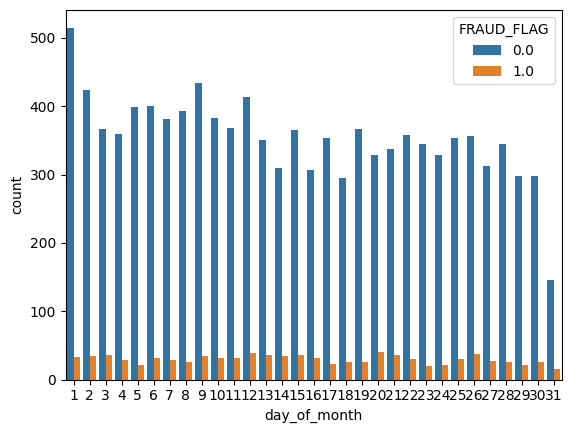

In [ ]:
sns.countplot(data=train_df, x="day_of_month", hue="FRAUD_FLAG")
plt.show()

In [ ]:
train_df["day_of_month_categorized"] = pd.cut(train_df["day_of_month"], bins=[1, 10, 20, 31], labels=[0, 1, 2])

test_df["day_of_month_categorized"] = pd.cut(test_df["day_of_month"], bins=[1, 10, 20, 31], labels=[0, 1, 2])

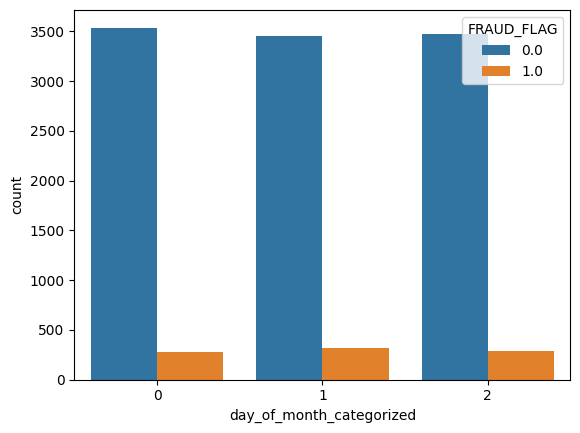

In [ ]:
sns.countplot(data=train_df, x="day_of_month_categorized", hue="FRAUD_FLAG")
plt.show()

In [ ]:
train_df["day_of_month_categorized"] = pd.cut(train_df["day_of_month"], bins=[1, 15, 31], labels=[0, 1])

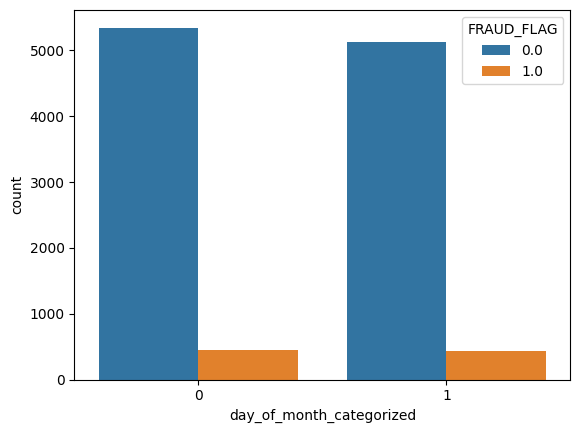

In [ ]:
sns.countplot(data=train_df, x="day_of_month_categorized", hue="FRAUD_FLAG")
plt.show()

In [ ]:
train_df.drop(["day_of_month", "day_of_month_categorized"], inplace=True, axis=1)

test_df.drop(["day_of_month", "day_of_month_categorized"], inplace=True, axis=1)

### "PAGE_NAME": A fascinating story

Hang tight – we're embarking on a mission to bid farewell to those pesky duplicates that have infiltrated our combined dataset. The culprits? Special characters and spaces causing chaos.

Our secret weapon? A thorough cleaning session. We're removing unwanted characters, tidying up spaces, and giving those duplicates a firm warning.

In [ ]:
unique_values = set(",".join(train_df["PAGE_NAME"]).split(","))
unique_values = {s.strip(" '\"{}") for s in unique_values}
unique_values

{'2-factor-authentication',
 'account-settings',
 'add-payment-method',
 'add-shipping-address',
 'add-to-cart',
 'checkout',
 'forgot-password',
 'home-page',
 'order-complete',
 'order-history',
 'payment-failed',
 'search-results',
 'sign-in',
 'sign-up',
 'update-payment-method',
 'update-shipping-address',
 'view-cart',
 'view-product'}

Get ready for a twist in the tale as we plunge into the realm of client online banking events. We're on the brink of unveiling a table that illuminates the discrepancies in fraud percentages across various events – providing insight into the intricate dance between events and fraud.

Brace yourself for surprises: our discoveries defy conventional wisdom. It appears that the percentage of frauds associated with 2-factor authentication is higher among fraud cases compared to non-frauds.

But the intrigue doesn't end there. We're not mere spectators – we're selectors, pinpointing the events where the disparity between frauds and non-frauds is notable. Equipped with a flag column that signals a 0 or 1, we're curating variables that capture the essence of this distinction.

In [ ]:
fr = (train_df["FRAUD_FLAG"] == 1).sum()
non_fr = (train_df["FRAUD_FLAG"] == 0).sum()

fraud_nums = []
non_fraud_nums = []
page_name = list(unique_values)

for page in unique_values:
    mask = train_df["FRAUD_FLAG"] == 1
    mask &= train_df["PAGE_NAME"].str.contains(page)
    filtered_df = train_df[mask]
    fraud_nums.append(len(filtered_df))

    mask = train_df["FRAUD_FLAG"] == 0
    mask &= train_df["PAGE_NAME"].str.contains(page)
    filtered_df = train_df[mask]
    non_fraud_nums.append(len(filtered_df))

fruad_by_page = pd.DataFrame({"fraud #": fraud_nums, "non_fraud #": non_fraud_nums}, index=page_name)
fruad_by_page["fraud %"] =  round(fruad_by_page["fraud #"] / fr *100, 2)
fruad_by_page["non_fraud %"] =  round(fruad_by_page["non_fraud #"] / non_fr * 100, 2)
fruad_by_page

,fraud #,non_fraud #,fraud %,non_fraud %
order-complete,918,10985,100.00,100.00
payment-failed,285,1784,31.05,16.24
account-settings,518,5061,56.43,46.07
order-history,447,4926,48.69,44.84
add-shipping-address,387,2224,42.16,20.25
forgot-password,199,1198,21.68,10.91
view-product,882,10481,96.08,95.41
update-payment-method,346,2025,37.69,18.43
search-results,880,10284,95.86,93.62
add-payment-method,406,3363,44.23,30.61


In [ ]:
new_page_vars = ["add-shipping-address" , "add-payment-method", "payment-failed", "update-shipping-address",
                 "update-payment-method", "forgot-password"]

In [ ]:
set_col = "PAGE_NAME"
target_col = "FRAUD_FLAG"
for val in new_page_vars:
    new_column = str(val)
    train_df[new_column] = (train_df[set_col].apply(lambda x: val in x))
    train_df[new_column] = train_df[val].astype(int)

for val in new_page_vars:
    new_column = str(val)
    test_df[new_column] = (test_df[set_col].apply(lambda x: val in x))
    test_df[new_column] = test_df[val].astype(int)

In [ ]:
for col in new_page_vars:
    train_df[col] = train_df[col].astype("category")

for col in new_page_vars:
    test_df[col] = test_df[col].astype("category")

In [ ]:
train_df.drop("PAGE_NAME", inplace=True, axis=1)

test_df.drop("PAGE_NAME", inplace=True, axis=1)

### BROWSER_FAMILY

In [ ]:
train_df["BROWSER_FAMILY"].unique()

array(['Mobile Safari', 'Mobile Safari UI/WKWebView', 'Edge', 'Android',
       'Firefox', 'Chrome Mobile', 'Chrome', 'Safari',
       'Chrome Mobile iOS', 'Samsung Internet', 'Google',
       'Chrome Mobile WebView', 'Firefox Mobile', 'Edge Mobile',
       'Apple Mail', 'Amazon Silk', 'Yandex Browser', 'Opera'],
      dtype=object)

In [ ]:
train_df[train_df["FRAUD_FLAG"] == 1]["BROWSER_FAMILY"].value_counts(normalize=True)*100

Mobile Safari UI/WKWebView    50.217865
Android                       20.588235
Firefox                       11.002179
Chrome                         9.477124
Chrome Mobile                  2.723312
Edge                           2.396514
Mobile Safari                  2.287582
Safari                         0.435730
Samsung Internet               0.435730
Chrome Mobile iOS              0.217865
Chrome Mobile WebView          0.217865
Name: BROWSER_FAMILY, dtype: float64

In [ ]:
train_df[train_df["FRAUD_FLAG"] == 0]["BROWSER_FAMILY"].value_counts(normalize=True)*100

Mobile Safari UI/WKWebView    64.578971
Android                       21.611288
Chrome                         6.954939
Edge                           2.548930
Safari                         1.256259
Chrome Mobile                  0.910332
Firefox                        0.873919
Mobile Safari                  0.755576
Samsung Internet               0.218480
Chrome Mobile iOS              0.109240
Google                         0.063723
Chrome Mobile WebView          0.036413
Firefox Mobile                 0.027310
Amazon Silk                    0.018207
Edge Mobile                    0.009103
Apple Mail                     0.009103
Yandex Browser                 0.009103
Opera                          0.009103
Name: BROWSER_FAMILY, dtype: float64

It's time to address the Browser Family – a column with its own story to tell. We've made a decision, and here's the lowdown: Browser Family is bidding farewell to our analysis.

Why, you may wonder? Well, it's a combination of factors. While certain categories like Safari show intriguing activity, there's the persistent issue of duplicates that require attention. However, there's a larger contender in the arena – OS Family. We have a strong intuition that this trend in operating systems holds more significance and insight compared to browsers.

In [ ]:
train_df.drop("BROWSER_FAMILY", inplace=True, axis=1)

test_df.drop("BROWSER_FAMILY", inplace=True, axis=1)

### OS_FAMILY

In [ ]:
print("percentage of frauds in different operation systems:")
train_df[train_df["FRAUD_FLAG"] == 1]["OS_FAMILY"].value_counts(normalize=True)*100

percentage of frauds in different operation systems:


iOS          52.723312
Android      23.965142
Windows      21.677560
Mac OS X      0.762527
Linux         0.653595
Chrome OS     0.217865
Name: OS_FAMILY, dtype: float64

In [ ]:
print("percentage of non-frauds in different operation systems:")
train_df[train_df["FRAUD_FLAG"] == 0]["OS_FAMILY"].value_counts(normalize=True)*100

percentage of non-frauds in different operation systems:


iOS          65.516614
Android      22.940373
Windows       8.866636
Mac OS X      2.375967
Chrome OS     0.154756
Linux         0.081930
Ubuntu        0.036413
Fedora        0.027310
Name: OS_FAMILY, dtype: float64

Get ready for an exhilarating dive into the realm of OS dynamics. We're zeroing in on a significant gap – the disparity between frauds and non-frauds in "Windows." This is where the plot thickens, and our analysis takes an exciting turn.

Without further ado, allow us to introduce the stars of the show: our freshly crafted OS Family categories. We've segmented the field into four distinct groups: iOS, Android, Windows, and the mysterious "Other."

Each category harbors its own intrigue, its own narratives of user behaviors and event dynamics. With this revamped categorization, we're poised to unearth deeper insights into the captivating interplay between OS and fraud. So, buckle up for an enthralling journey ahead!

In [ ]:
mapping = {"iOS": 0, "Android":1, "Windows":2, "Mac OS X":3, "Chrome OS":3, "Linux":3, "Ubuntu":3, "Fedora":3}

train_df["OS_FAMILY_categorized"] = train_df["OS_FAMILY"].map(mapping)

test_df["OS_FAMILY_categorized"] = test_df["OS_FAMILY"].map(mapping)

In [ ]:
train_df[train_df["FRAUD_FLAG"] == 1]["OS_FAMILY_categorized"].value_counts(normalize=True)*100

0    52.723312
1    23.965142
2    21.677560
3     1.633987
Name: OS_FAMILY_categorized, dtype: float64

In [ ]:
train_df[train_df["FRAUD_FLAG"] == 0]["OS_FAMILY_categorized"].value_counts(normalize=True)*100

0    65.516614
1    22.940373
2     8.866636
3     2.676377
Name: OS_FAMILY_categorized, dtype: float64

In [ ]:
train_df.drop("OS_FAMILY", axis=1, inplace=True)

test_df.drop("OS_FAMILY", axis=1, inplace=True)

In [ ]:
one_hot_encoded_train = pd.get_dummies(train_df["OS_FAMILY_categorized"])
one_hot_encoded_test = pd.get_dummies(test_df["OS_FAMILY_categorized"])
one_hot_encoded_train.head()

,0,1,2,3
0,1,0,0,0
1,1,0,0,0
2,0,0,1,0
3,0,1,0,0
4,1,0,0,0


In [ ]:
one_hot_encoded_test.head()

,0,1,2,3
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,0,1,0,0


In [ ]:
one_hot_encoded_train.columns = ["OS_FAMILY_categorized_0", "OS_FAMILY_categorized_1", "OS_FAMILY_categorized_2",
                           "OS_FAMILY_categorized_3"]
train_df = pd.concat([train_df, one_hot_encoded_train], axis=1)

one_hot_encoded_test.columns = ["OS_FAMILY_categorized_0", "OS_FAMILY_categorized_1", "OS_FAMILY_categorized_2",
                           "OS_FAMILY_categorized_3"]
test_df = pd.concat([test_df, one_hot_encoded_test], axis=1)


train_df.drop("OS_FAMILY_categorized", axis=1, inplace=True)
test_df.drop("OS_FAMILY_categorized", axis=1, inplace=True)

### 'DEVICE_FAMILY', 'DEVICE_BRAND', 'DEVICE_MODEL'

In [ ]:
print(train_df[train_df["FRAUD_FLAG"] == 1]["DEVICE_FAMILY"].value_counts(normalize=True)*100)
print()
print(train_df[train_df["FRAUD_FLAG"] == 0]["DEVICE_FAMILY"].value_counts(normalize=True)*100)

iPhone                52.069717
Other                 22.549020
Generic Smartphone     1.742919
Samsung SM-G930W8      1.416122
Samsung SM-G950W       1.307190
                        ...    
Samsung SM-N950W       0.108932
Pixel 4 XL             0.108932
Oppo CPH2043           0.108932
Samsung SM-A127M       0.108932
Samsung SM-A526W       0.108932
Name: DEVICE_FAMILY, Length: 62, dtype: float64

iPhone               63.686846
Other                 9.167046
Mac                   2.375967
Samsung SM-G781W      2.203004
iPad                  1.802458
                       ...    
Samsung SM-G900W8     0.009103
Samsung SM-N986U1     0.009103
Samsung SM-A102U      0.009103
Samsung SM-A305G      0.009103
Samsung SM-G970U      0.009103
Name: DEVICE_FAMILY, Length: 351, dtype: float64


In [ ]:
print(train_df[train_df["FRAUD_FLAG"] == 1]["DEVICE_BRAND"].value_counts(normalize=True)*100)
print()
print(train_df[train_df["FRAUD_FLAG"] == 0]["DEVICE_BRAND"].value_counts(normalize=True)*100)

Apple              69.057665
Samsung            22.644163
Generic             2.250352
Google              1.547117
Motorola            1.265823
Huawei              1.125176
Generic_Android     0.843882
ZTE                 0.562588
Oppo                0.281294
OnePlus             0.281294
vivo                0.140647
Name: DEVICE_BRAND, dtype: float64

Apple                     74.744438
Samsung                   18.791341
Google                     1.763881
Generic                    1.663660
Huawei                     0.781720
Motorola                   0.691521
OnePlus                    0.330728
Oppo                       0.300661
Generic_Android            0.250551
XiaoMi                     0.230507
vivo                       0.140309
Generic_Android_Tablet     0.110243
LG                         0.110243
Asus                       0.030066
Amazon                     0.020044
Nokia                      0.010022
Tecno                      0.010022
Infinix                    0.0100

In [ ]:
print(train_df[train_df["FRAUD_FLAG"] == 1]["DEVICE_MODEL"].value_counts(normalize=True)*100)
print()
print(train_df[train_df["FRAUD_FLAG"] == 0]["DEVICE_MODEL"].value_counts(normalize=True)*100)

iPhone        67.229255
Smartphone     2.250352
SM-G930W8      1.828411
SM-G950W       1.687764
SM-G960W       1.547117
                ...    
g fast         0.140647
SM-N950W       0.140647
CPH2043        0.140647
SM-A127M       0.140647
SM-A715W       0.140647
Name: DEVICE_MODEL, Length: 61, dtype: float64

iPhone            70.114251
Mac                2.615755
SM-G781W           2.425336
iPad               1.984366
Smartphone         1.663660
                    ...    
rola edge plus     0.010022
SM-G386W           0.010022
SM-A325F           0.010022
OnePlus BE2012     0.010022
SM-G970U           0.010022
Name: DEVICE_MODEL, Length: 344, dtype: float64


In [ ]:
train_df.drop(['DEVICE_FAMILY', 'DEVICE_BRAND', 'DEVICE_MODEL'], axis=1, inplace=True)

test_df.drop(['DEVICE_FAMILY', 'DEVICE_BRAND', 'DEVICE_MODEL'], axis=1, inplace=True)

### 'TIME_SPENT'

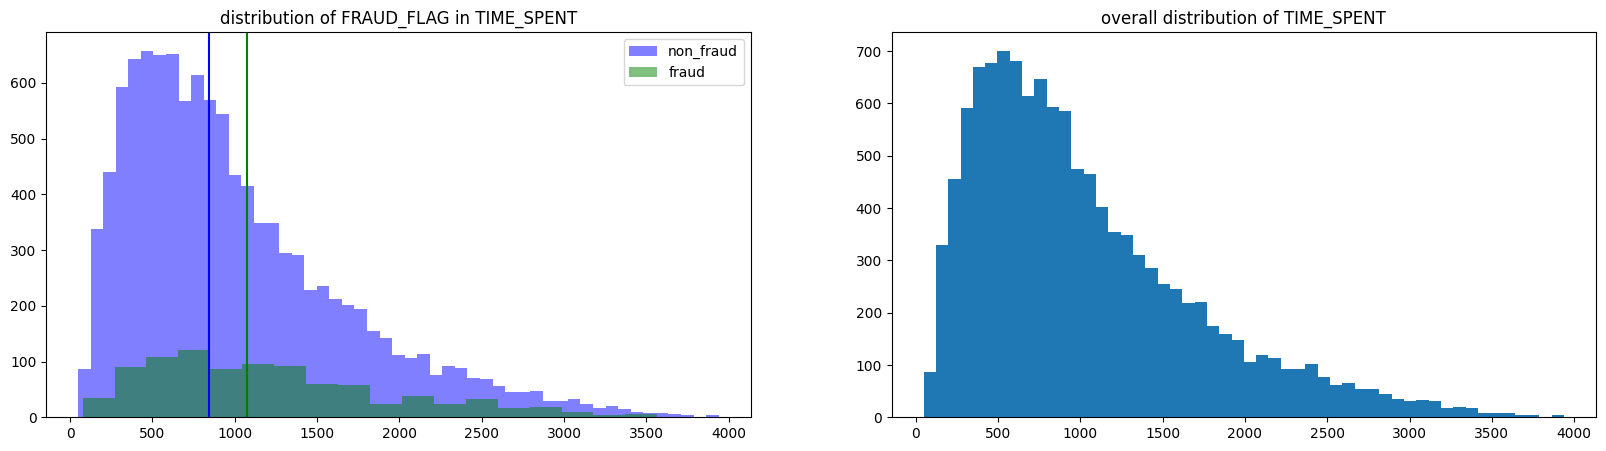

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].hist(train_df[train_df["FRAUD_FLAG"]==0]["TIME_SPENT"], bins="auto", alpha=0.5, color="blue", label="non_fraud")
axs[0].hist(train_df[train_df["FRAUD_FLAG"]==1]["TIME_SPENT"], bins="auto", alpha=0.5, color="green", label="fraud")
axs[0].legend()
axs[0].axvline(x=train_df[train_df["FRAUD_FLAG"]==0]["TIME_SPENT"].median(), color="blue")
axs[0].axvline(x=train_df[train_df["FRAUD_FLAG"]==1]["TIME_SPENT"].median(), color="green")
axs[0].set_title("distribution of FRAUD_FLAG in TIME_SPENT")

axs[1].hist(train_df["TIME_SPENT"], bins="auto")
axs[1].set_title("overall distribution of TIME_SPENT")

plt.show()

log transformation on the column

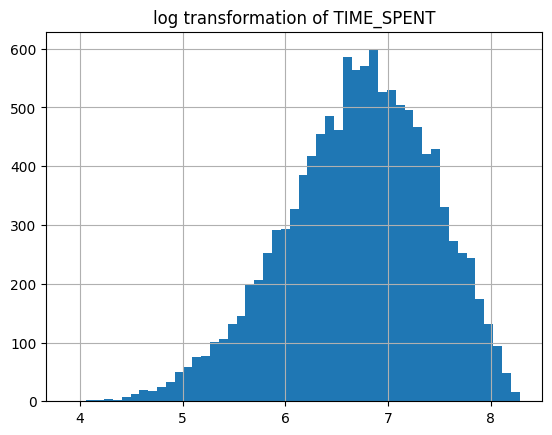

In [ ]:
np.log(train_df["TIME_SPENT"]).hist(bins="auto")
plt.title("log transformation of TIME_SPENT")
plt.show()

After to the log transformation, the column's distribution now holds a more enchanting resemblance to normality.

So, we're not just waving goodbye to the old, we're embracing the new. The log-transformed column is taking center stage, and the original is bowing out.

In [ ]:
train_df["TIME_SPENT_log_transformed"] = np.log(train_df["TIME_SPENT"])
test_df["TIME_SPENT_log_transformed"] = np.log(test_df["TIME_SPENT"])

In [ ]:
train_df.drop("TIME_SPENT", axis=1, inplace=True)

test_df.drop("TIME_SPENT", axis=1, inplace=True)

### CITY

In [ ]:
city_frauds_overall = []
city_non_frauds_overall = []

city_frauds_percentage = []
city_non_frauds_percentage = []

fr = len(train_df[train_df["FRAUD_FLAG"] == 1])
non_fr = len(train_df[train_df["FRAUD_FLAG"] == 0])

cities = pd.DataFrame(train_df["CITY"].value_counts(normalize=True) * 100)
cities = cities.rename(columns={"CITY": "total transactions %"})

for col in cities.index:
    percentage_fraud = len(train_df[(train_df["FRAUD_FLAG"] == 1) & (train_df["CITY"] == col)]) / fr *100
    city_frauds_overall.append(percentage_fraud)

    percentage_non_fraud = len(train_df[(train_df["FRAUD_FLAG"] == 0) & (train_df["CITY"] == col)]) / non_fr *100
    city_non_frauds_overall.append(percentage_non_fraud)

cities["frauds (in all transactions) %"] = city_frauds_overall
cities["non_frauds (in all transactions) %"] = city_non_frauds_overall

sorted_indexes = cities["frauds (in all transactions) %"].sort_values(ascending= False).index

cities_sorted = cities.reindex(sorted_indexes)
cities_sorted.head(20)

,total transactions %,frauds (in all transactions) %,non_frauds (in all transactions) %
toronto,12.694279,16.557734,12.371416
montreal,5.208771,15.141612,4.378698
scarborough,2.041502,4.901961,1.802458
brampton,5.065950,4.466231,5.116067
morinville,0.302445,3.703704,0.018207
mississauga,2.142317,3.267974,2.048248
dallas,0.285642,3.159041,0.045517
vancouver,4.335042,2.614379,4.478835
calgary,5.158363,2.505447,5.380064
ottawa,2.234731,1.851852,2.266727


Imagine a world filled with bustling cities, countless transactions, and the ever-present specter of fraud. We embarked on a quest to shine a spotlight on the cities hosting the most transactions and harboring the most intriguing fraud stories.

What ensued? We seamlessly melded these significant cities into a single captivating category, forging a new realm of insights. It's akin to blending the finest ingredients to concoct a dish of data magic.

But our tale doesn't end there – the remaining cities still play a vital role in our narrative, now grouped under the banner of "Other Cities." We're meticulously painting a detailed portrait of the cityscape, one brushstroke at a time, to unveil the complete landscape of our data journey.

In [ ]:
my_cities = ["toronto", "montreal", "scarborough", "brampton", "morinville", "mississauga", "dallas",
             "vancouver", "calgary", "ottawa", "maple", "edmonton"]

train_df["city_categorical"] = np.where(train_df["CITY"].isin(my_cities), 1, 0)
train_df["city_categorical"] = train_df["city_categorical"].fillna(0)

test_df["city_categorical"] = np.where(test_df["CITY"].isin(my_cities), 1, 0)
test_df["city_categorical"] = test_df["city_categorical"].fillna(0)

In [ ]:
train_df["city_categorical"].value_counts(normalize=True) * 100


0    56.809208
1    43.190792
Name: city_categorical, dtype: float64

In [ ]:
train_df["city_categorical"] = train_df["city_categorical"].astype("category")

test_df["city_categorical"] = test_df["city_categorical"].astype("category")

In [ ]:
train_df.drop("CITY", axis=1, inplace=True)

test_df.drop("CITY", axis=1, inplace=True)

In [ ]:
print(train_df.shape)
print(test_df.shape)
train_df.head(2)

(11903, 113)
(2976, 113)


,FRAUD_FLAG,AVAIL_CRDT,AMOUNT,FLAG_LX,FLAG_AUTO,FLAG_APPAREL,FLAG_DEAL,FLAG_RECREA,FLAG_ENTERTAINMENT,FLAG_GIFT_CARD,...,payment-failed,update-shipping-address,update-payment-method,forgot-password,OS_FAMILY_categorized_0,OS_FAMILY_categorized_1,OS_FAMILY_categorized_2,OS_FAMILY_categorized_3,TIME_SPENT_log_transformed,city_categorical
0,1.0,7420.73,69.70,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,5.973810,1
1,0.0,3825.90,1.02,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,6.911747,1


last check to make sure we have the same number of columns with the same name in the both test and train sets

In [ ]:
train_df.isna().sum().sort_values(ascending=False)

FRAUD_FLAG                     0
MEAN_HIGH_AMT_PAST_30DAY       0
COUNT_FASTFOOD_PAST_30DAY      0
COUNT_GIFT_CARD_PAST_30DAY     0
SUM_WEEKEND_PAST_30DAY         0
                              ..
MEAN_WEEKEND_PAST_7DAY         0
MEAN_SWIPE_PAST_7DAY           0
MEAN_ELCTRNCS_PAST_7DAY        0
MEAN_MANUAL_ENTRY_PAST_7DAY    0
city_categorical               0
Length: 113, dtype: int64

### Saving the transformed dataseta

In [ ]:
train_df.to_csv("train_after_EDA_2.csv", index=False)
test_df.to_csv("test_after_EDA_2.csv", index=False)

# Model Building

Loading the dataset

In [ ]:
train_df= pd.read_csv("/content/train_after_EDA_2.csv")
test_df= pd.read_csv("/content/test_after_EDA_2.csv")

print(train_df.shape)
print(test_df.shape)

(11903, 113)
(2976, 113)


In [ ]:
train_df_1 = train_df.copy()
test_df_1 = test_df.copy()

In [ ]:
X = train_df_1.drop("FRAUD_FLAG", axis=1)
y = train_df_1["FRAUD_FLAG"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print("X_train.shape:", X_train.shape, "   X_test.shape:",X_test.shape, "   y_train.shape:", y_train.shape, "   y_test.shape:", y_test.shape)

X_train.shape: (8332, 112)    X_test.shape: (3571, 112)    y_train.shape: (8332,)    y_test.shape: (3571,)


## 1. No oversampling

The first try is with the model from the previous section which is an imbalanced dataset

### Decision Trees

Best Parameters:
{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 9}

cross validation score:
[0.93581284 0.94061188 0.94177671 0.93217287 0.94057623]

#####################         Train results         #####################
f1 score: 0.5341726618705036

conf_matrix:
[[7517  172]
 [ 346  297]]

precision score: 0.6332622601279317

recall score: 0.4618973561430793

auc_roc: 0.774715125948948


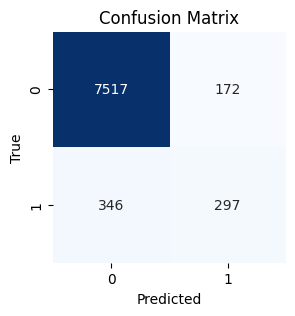

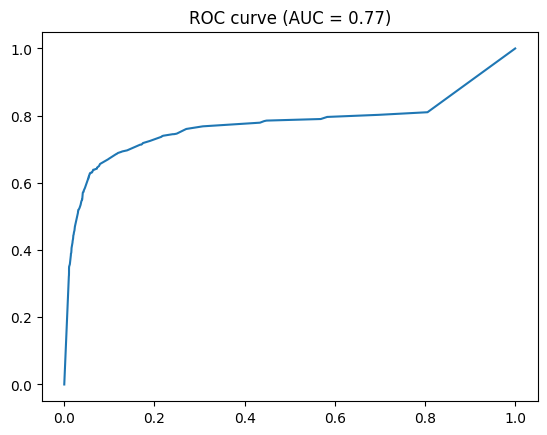


#####################         Test results         #####################
f1 score: 0.5161290322580645

conf_matrix:
[[3226   70]
 [ 155  120]]

precision score: 0.631578947368421

recall score: 0.43636363636363634

auc_roc: 0.8011904236540158


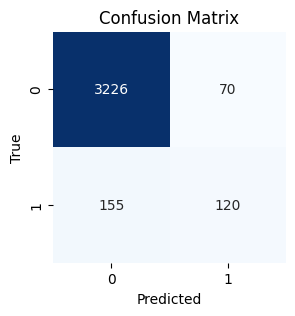

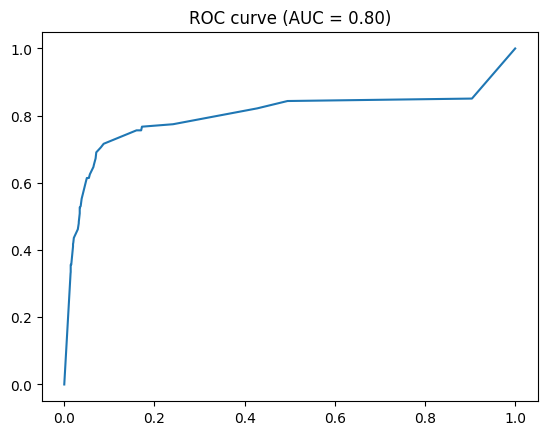

In [ ]:
DT_1 = DecisionTreeClassifier()

param_grid = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": randint(low=2, high=30),
    "min_samples_leaf": randint(low=1, high=5),
    "max_features": [None, "sqrt", "log2"],
}

random_search = RandomizedSearchCV(
    estimator = DT_1,
    param_distributions = param_grid,
    n_iter = 20,
    scoring = make_scorer(f1_score),
    cv = 5,
    random_state = 42
)

random_search.fit(X_train, y_train)

best_model_DT_1 = random_search.best_estimator_
best_params_DT_1 = random_search.best_params_

cross_val_score_DT_1 = cross_val_score(best_model_DT_1, X_train, y_train, cv=5)

print("Best Parameters:")
print(best_params_DT_1)
print()
print("cross validation score:")
print(cross_val_score_DT_1)
print()

y_train_pred_DT_1 = cross_val_predict(best_model_DT_1, X_train, y_train, cv=5)
y_train_pred_proba_DT_1 = cross_val_predict(best_model_DT_1, X_train, y_train, cv=5, method="predict_proba")[:, 1]

importance_DT_1 = best_model_DT_1.feature_importances_

print("#####################         Train results         #####################")
f1 = f1_score(y_train, y_train_pred_DT_1)
conf_matrix = confusion_matrix(y_train, y_train_pred_DT_1)
precision = precision_score(y_train, y_train_pred_DT_1)
recall = recall_score(y_train, y_train_pred_DT_1)
auc_roc = roc_auc_score(y_train, y_train_pred_proba_DT_1)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_proba_DT_1)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()



y_test_pred_DT_1 = best_model_DT_1.predict(X_test)
y_test_pred_proba_DT_1 = best_model_DT_1.predict_proba(X_test)[:,1]

print()
print("#####################         Test results         #####################")
f1 = f1_score(y_test, y_test_pred_DT_1)
auc_roc = roc_auc_score(y_test, y_test_pred_proba_DT_1)
conf_matrix = confusion_matrix(y_test, y_test_pred_DT_1)
precision = precision_score(y_test, y_test_pred_DT_1)
recall = recall_score(y_test, y_test_pred_DT_1)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_DT_1)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()

The results in both train and test sets are fairly low. so, we'll perform oversampling to see if we can have a higher performance or not

## 2. no feature selection , no scaling, no outlier detection, WITH oversampling

### 2.1. Oversampling

In [ ]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
y_train_resampled.value_counts()

0.0    7689
1.0    7689
Name: FRAUD_FLAG, dtype: int64

### Decision Trees (oversampled)

Best Parameters:
{'max_depth': 20, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 16}

cross validation score:
[0.87906372 0.9479844  0.94148244 0.94796748 0.94504065]

#####################         Train results         #####################
f1 score: 0.9320311987939962

conf_matrix:
[[7231  458]
 [ 579 7110]]

precision score: 0.9394820295983086

recall score: 0.92469761997659

auc_roc: 0.9573901424510707


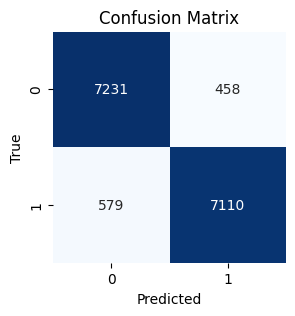

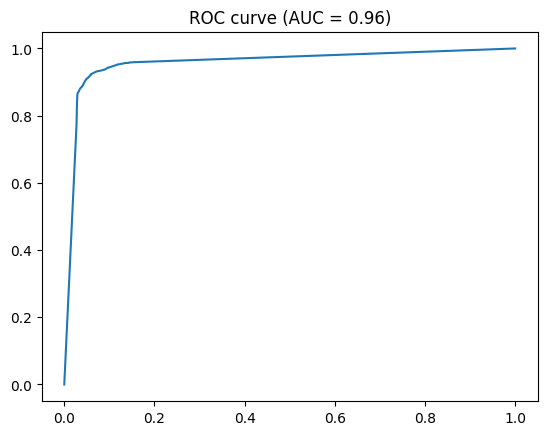


#####################         Test results         #####################
f1 score: 0.4385964912280701

conf_matrix:
[[3126  170]
 [ 150  125]]

precision score: 0.423728813559322

recall score: 0.45454545454545453

auc_roc: 0.7884002647837599


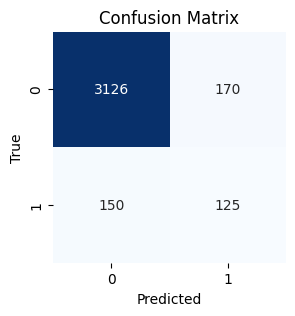

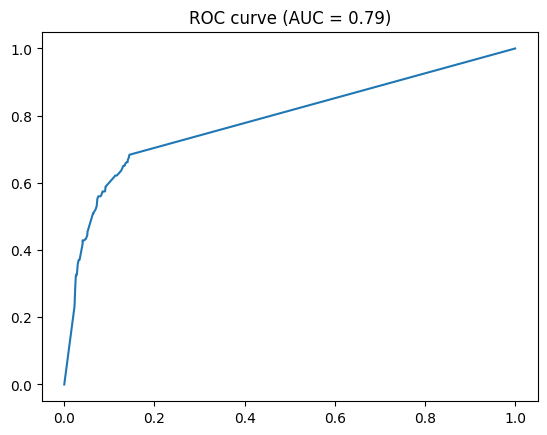

In [ ]:
DT_2 = DecisionTreeClassifier()

param_grid = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": randint(low=2, high=30),
    "min_samples_leaf": randint(low=1, high=5),
    "max_features": [None, "sqrt", "log2"],
}

random_search = RandomizedSearchCV(
    estimator = DT_2,
    param_distributions = param_grid,
    n_iter = 20,
    scoring = make_scorer(f1_score),
    cv = 5,
    random_state = 42
)

random_search.fit(X_train_resampled, y_train_resampled)

best_model_DT_2 = random_search.best_estimator_
best_params_DT_2 = random_search.best_params_

cross_val_score_DT_2 = cross_val_score(best_model_DT_2, X_train_resampled, y_train_resampled, cv=5)

print("Best Parameters:")
print(best_params_DT_2)
print()
print("cross validation score:")
print(cross_val_score_DT_2)
print()

y_train_pred_DT_2 = cross_val_predict(best_model_DT_2, X_train_resampled, y_train_resampled, cv=5)
y_train_pred_proba_DT_2 = cross_val_predict(best_model_DT_2, X_train_resampled, y_train_resampled, cv=5, method="predict_proba")[:, 1]

importance_DT_2 = best_model_DT_2.feature_importances_


print("#####################         Train results         #####################")
f1 = f1_score(y_train_resampled, y_train_pred_DT_2)
conf_matrix = confusion_matrix(y_train_resampled, y_train_pred_DT_2)
precision = precision_score(y_train_resampled, y_train_pred_DT_2)
recall = recall_score(y_train_resampled, y_train_pred_DT_2)
auc_roc = roc_auc_score(y_train_resampled, y_train_pred_proba_DT_2)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_train_resampled, y_train_pred_proba_DT_2)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()


y_test_pred_DT_2 = best_model_DT_2.predict(X_test)
y_test_pred_proba_DT_2 = best_model_DT_2.predict_proba(X_test)[:,1]

print()
print("#####################         Test results         #####################")
f1 = f1_score(y_test, y_test_pred_DT_2)
auc_roc = roc_auc_score(y_test, y_test_pred_proba_DT_2)
conf_matrix = confusion_matrix(y_test, y_test_pred_DT_2)
precision = precision_score(y_test, y_test_pred_DT_2)
recall = recall_score(y_test, y_test_pred_DT_2)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_DT_2)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()

after applying oversampling, we noticed that the performance metrics in training dataset improved dramatically. however, there is a noticeable gap between train and test results. so, we have overfitting.

## 3. dealing with overfitting

our data is overfitting So, we need to work on features and feature selection to have a better combination of features. We'll do the following:

- First, removing the features with one unique values
- Applying Lasso (L1 regularization) to perform feature selection
- Applying Random Forest and using the fetures with over 3% importance, as a feature selection technique

### 3.1. First layer of feature selection

In [ ]:
one_or_zer_unique_val_features = [col for col in train_df.columns if train_df[col].nunique() <= 1]
print("columns with one or zero unique values:")
print(one_or_zer_unique_val_features)

columns with one or zero unique values:
['FLAG_RECREA', 'FLAG_FASTFOOD', 'FLAG_GAS', 'FLAG_HIGH_RECREA', 'FLAG_INTERNET', 'FLAG_MANUAL_ENTRY', 'FLAG_SWIPE']


In [ ]:
auto_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("auto")])
fastfood_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("fast")])
gas_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("gas")])
high_recrea_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("high_recrea")])
internet_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("internet")])
fashion_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("fashion")])
manual_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("manual")])
swipe_columns = list(train_df.columns[train_df.columns.str.lower().str.contains("swipe")])
temp = list(train_df.columns[train_df.columns.str.lower().str.contains("recrea")])
recrea_columns = [col for col in temp if col not in high_recrea_columns]

print(auto_columns)
print()
print(fastfood_columns)
print()
print(gas_columns)
print()
print(high_recrea_columns)
print()
print(internet_columns)
print()
print(fashion_columns)
print()
print(manual_columns)
print()
print(swipe_columns)
print()
print(recrea_columns)
print()
print(len(auto_columns) + len(fastfood_columns) + len(gas_columns) + len(high_recrea_columns) + len(internet_columns) + len(fashion_columns)\
      + len(manual_columns) + len(swipe_columns) + len(recrea_columns))

['FLAG_AUTO', 'MEAN_AUTO_PAST_7DAY', 'COUNT_AUTO_PAST_7DAY', 'MEAN_AUTO_PAST_30DAY', 'STD_AUTO_PAST_30DAY', 'SUM_AUTO_PAST_30DAY', 'auto_mean_ratio', 'auto_sum_ratio']

['FLAG_FASTFOOD', 'MEAN_FASTFOOD_PAST_7DAY', 'STD_FASTFOOD_PAST_7DAY', 'MAX_FASTFOOD_PAST_30DAY', 'SUM_FASTFOOD_PAST_30DAY', 'COUNT_FASTFOOD_PAST_30DAY']

['FLAG_GAS', 'gas_sum7_count7_ratio', 'gas_sum30_count30_ratio']

['FLAG_HIGH_RECREA', 'MAX_HIGH_RECREA_PAST_7DAY', 'STD_HIGH_RECREA_PAST_30DAY', 'SUM_HIGH_RECREA_PAST_30DAY']

['FLAG_INTERNET', 'STD_INTERNET_PAST_7DAY', 'COUNT_INTERNET_PAST_7DAY', 'STD_INTERNET_PAST_30DAY', 'SUM_INTERNET_PAST_30DAY']

['FLAG_FASHION', 'MEAN_FASHION_PAST_7DAY']

['FLAG_MANUAL_ENTRY', 'MEAN_MANUAL_ENTRY_PAST_7DAY', 'COUNT_MANUAL_ENTRY_PAST_7DAY', 'MEAN_MANUAL_ENTRY_PAST_30DAY', 'SUM_MANUAL_ENTRY_PAST_30DAY']

['FLAG_SWIPE', 'MEAN_SWIPE_PAST_7DAY', 'STD_SWIPE_PAST_7DAY', 'SUM_SWIPE_PAST_7DAY', 'swipe_sum30_count30_ratio']

['FLAG_RECREA', 'MEAN_RECREA_PAST_7DAY', 'STD_RECREA_PAST_30DAY'

In [ ]:
features_to_drop = auto_columns + fastfood_columns + gas_columns + high_recrea_columns + internet_columns + fashion_columns + manual_columns + swipe_columns + recrea_columns
new_features = [col for col in X_train_resampled.columns if col not in features_to_drop]

X_train_one_unique_feature = X_train_resampled[new_features]
X_test_one_unique_feature = X_test[new_features]

print(X_train_one_unique_feature.shape, X_test_one_unique_feature.shape)

(15378, 70) (3571, 70)


In [ ]:
X_train_one_unique_feature.head(2)

,AVAIL_CRDT,AMOUNT,FLAG_LX,FLAG_APPAREL,FLAG_DEAL,FLAG_ENTERTAINMENT,FLAG_GIFT_CARD,FLAG_HIGH_AMT,FLAG_INTERNATIONAL,FLAG_LOW_AMT,...,payment-failed,update-shipping-address,update-payment-method,forgot-password,OS_FAMILY_categorized_0,OS_FAMILY_categorized_1,OS_FAMILY_categorized_2,OS_FAMILY_categorized_3,TIME_SPENT_log_transformed,city_categorical
0,11958.67,0.97,0,1,0,1,0,0,0,1,...,0,1,0,0,1,0,0,0,6.665684,1
1,0.00,28.70,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,7.177019,0


### 3.1.2. Applying the first layer of feature selection on Decision Trees

Best Parameters:
{'max_depth': 20, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 6}

cross validation score:
[0.86020806 0.94148244 0.94863459 0.94308943 0.94146341]

#####################         Train results         #####################
f1 score: 0.9268864850775447

conf_matrix:
[[7144  545]
 [ 577 7112]]

precision score: 0.9288232989421444

recall score: 0.9249577318246847

auc_roc: 0.9450133228246658


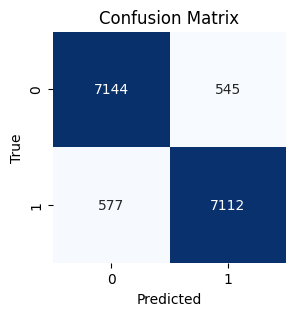

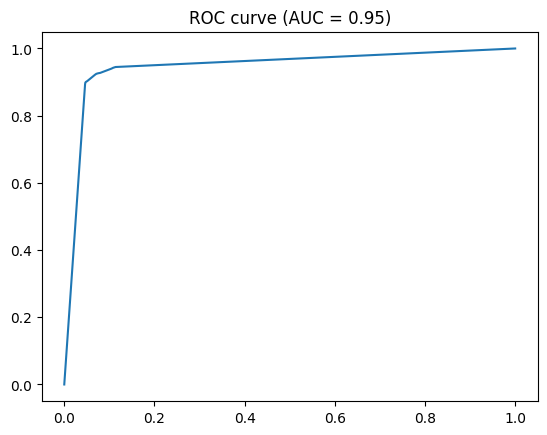


#####################         Test results         #####################
f1 score: 0.34904013961605584

conf_matrix:
[[3098  198]
 [ 175  100]]

precision score: 0.33557046979865773

recall score: 0.36363636363636365

auc_roc: 0.7084449470432479


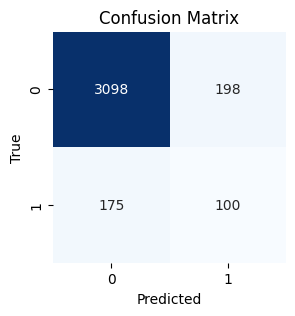

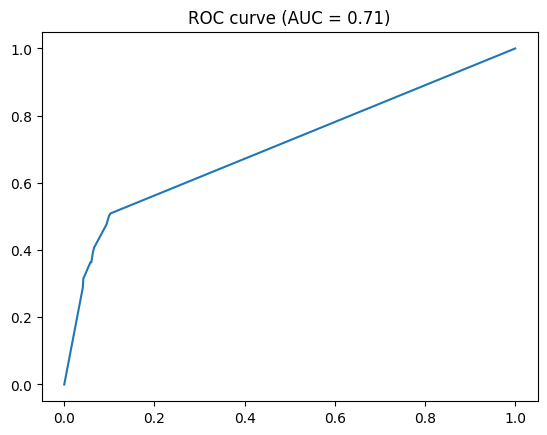

In [ ]:
DT_3_1 = DecisionTreeClassifier()

param_grid = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": randint(low=2, high=30),
    "min_samples_leaf": randint(low=1, high=5),
    "max_features": [None, "sqrt", "log2"],
}

random_search = RandomizedSearchCV(
    estimator = DT_3_1,
    param_distributions = param_grid,
    n_iter = 20,
    scoring = make_scorer(f1_score),
    cv = 5,
    random_state = 42
)

random_search.fit(X_train_one_unique_feature, y_train_resampled)

best_model_DT_3_1 = random_search.best_estimator_
best_params_DT_3_1 = random_search.best_params_

cross_val_score_DT_3_1 = cross_val_score(best_model_DT_3_1, X_train_one_unique_feature, y_train_resampled, cv=5)

print("Best Parameters:")
print(best_params_DT_3_1)
print()
print("cross validation score:")
print(cross_val_score_DT_3_1)
print()

y_train_pred_DT_3_1 = cross_val_predict(best_model_DT_3_1, X_train_one_unique_feature, y_train_resampled, cv=5)
y_train_pred_proba_DT_3_1 = cross_val_predict(best_model_DT_3_1, X_train_one_unique_feature, y_train_resampled,
                                            cv=5, method="predict_proba")[:, 1]

importance_DT_3_1 = best_model_DT_3_1.feature_importances_


print("#####################         Train results         #####################")
f1 = f1_score(y_train_resampled, y_train_pred_DT_3_1)
conf_matrix = confusion_matrix(y_train_resampled, y_train_pred_DT_3_1)
precision = precision_score(y_train_resampled, y_train_pred_DT_3_1)
recall = recall_score(y_train_resampled, y_train_pred_DT_3_1)
auc_roc = roc_auc_score(y_train_resampled, y_train_pred_proba_DT_3_1)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_train_resampled, y_train_pred_proba_DT_3_1)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()


y_test_pred_DT_3_1= best_model_DT_3_1.predict(X_test_one_unique_feature)
y_test_pred_proba_DT_3_1 = best_model_DT_3_1.predict_proba(X_test_one_unique_feature)[:,1]


print()
print("#####################         Test results         #####################")
f1 = f1_score(y_test, y_test_pred_DT_3_1)
auc_roc = roc_auc_score(y_test, y_test_pred_proba_DT_3_1)
conf_matrix = confusion_matrix(y_test, y_test_pred_DT_3_1)
precision = precision_score(y_test, y_test_pred_DT_3_1)
recall = recall_score(y_test, y_test_pred_DT_3_1)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_DT_3_1)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()

### 3.2. Applying the second layer of feature selection (Lasso)

In this step we apply the Lasso technique for feature selection

In [ ]:
lasso_cv_1 = LassoCV(alphas=[0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10], cv=5)
lasso_cv_1.fit(X_train_one_unique_feature, y_train_resampled)
best_alpha = lasso_cv_1.alpha_
print("best alpha:", best_alpha)

lasso_1 = Lasso(alpha = best_alpha)
lasso_1.fit(X_train_one_unique_feature, y_train_resampled)

feature_selector_1 = SelectFromModel(lasso_1, threshold="median")
feature_selector_1.fit(X_train_one_unique_feature, y_train_resampled)

selected_features_1 = feature_selector_1.get_support(indices=True)
print("length of selected features", len(selected_features_1))
X_train_selected_lasso = X_train_one_unique_feature.iloc[:, selected_features_1]
X_test_selected_lasso = X_test_one_unique_feature.iloc[:, selected_features_1]

print()
print("name of the selected features:")
print(X_train_one_unique_feature.columns[list(selected_features_1)])

print("shape of X_Train:", X_train_selected_lasso.shape)
print()
print("shape of X_Test:", X_test_selected_lasso.shape)
print()
X_train_selected_lasso.head(2)

best alpha: 0.0005
length of selected features 35

name of the selected features:
Index(['FLAG_LX', 'FLAG_APPAREL', 'FLAG_ENTERTAINMENT', 'FLAG_GIFT_CARD',
       'FLAG_HIGH_AMT', 'FLAG_INTERNATIONAL', 'FLAG_LOW_AMT', 'FLAG_ELCTRNCS',
       'MEAN_LOW_AMT_PAST_7DAY', 'STD_LOW_AMT_PAST_7DAY',
       'COUNT_ENTERTAINMENT_PAST_7DAY', 'COUNT_WEEKEND_PAST_7DAY',
       'MEAN_LOW_AMT_PAST_30DAY', 'STD_LOW_AMT_PAST_30DAY',
       'STD_PARTIAL_PAST_30DAY', 'COUNT_GIFT_CARD_PAST_30DAY',
       'COUNT_ELCTRNCS_PAST_30DAY', 'COUNT_WEEKEND_PAST_30DAY',
       'deal_mean30_sum30_ratio', 'gift_card_mean7_mean30_ratio',
       'day_of_week_categorized', 'hour_of_day_categorized_0',
       'hour_of_day_categorized_1', 'hour_of_day_categorized_2',
       'add-shipping-address', 'add-payment-method', 'update-shipping-address',
       'update-payment-method', 'forgot-password', 'OS_FAMILY_categorized_0',
       'OS_FAMILY_categorized_1', 'OS_FAMILY_categorized_2',
       'OS_FAMILY_categorized_3', 'TIME_

,FLAG_LX,FLAG_APPAREL,FLAG_ENTERTAINMENT,FLAG_GIFT_CARD,FLAG_HIGH_AMT,FLAG_INTERNATIONAL,FLAG_LOW_AMT,FLAG_ELCTRNCS,MEAN_LOW_AMT_PAST_7DAY,STD_LOW_AMT_PAST_7DAY,...,add-payment-method,update-shipping-address,update-payment-method,forgot-password,OS_FAMILY_categorized_0,OS_FAMILY_categorized_1,OS_FAMILY_categorized_2,OS_FAMILY_categorized_3,TIME_SPENT_log_transformed,city_categorical
0,0,1,1,0,0,0,1,0,5.64,6.2,...,0,1,0,0,1,0,0,0,6.665684,1
1,0,1,0,0,0,0,0,0,0.00,0.0,...,0,0,0,0,1,0,0,0,7.177019,0


By applying Lasso, the number of features is reduced to 35

### 3.3 Decision Trees after applying Lasso feature selection

Best Parameters:
{'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 8}

cross validation score:
[0.82119636 0.93855657 0.93985696 0.94536585 0.94601626]

#####################         Train results         #####################
f1 score: 0.9176098973414056

conf_matrix:
[[7154  535]
 [ 717 6972]]

precision score: 0.9287331823631277

recall score: 0.906749902458057

auc_roc: 0.9372550192681175


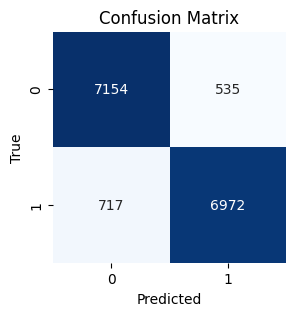

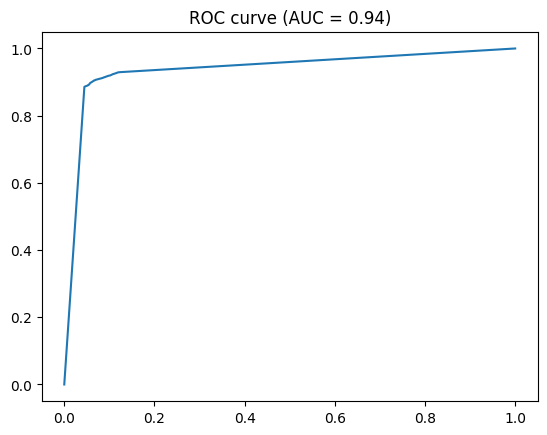


#####################         Test results         #####################
f1 score: 0.3415435139573071

conf_matrix:
[[3066  230]
 [ 171  104]]

precision score: 0.31137724550898205

recall score: 0.3781818181818182

auc_roc: 0.7240826345984113


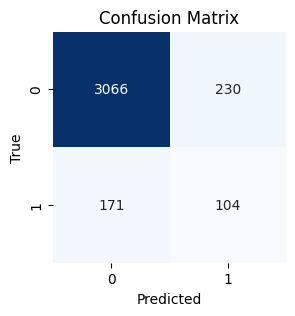

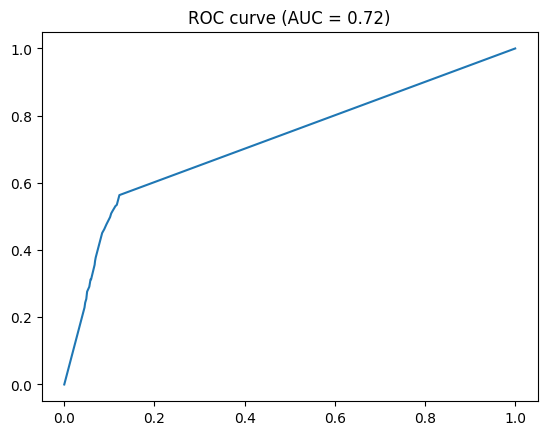

In [ ]:
DT_3_2 = DecisionTreeClassifier()

param_grid = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": randint(low=2, high=30),
    "min_samples_leaf": randint(low=1, high=5),
    "max_features": [None, "sqrt", "log2"],
}

random_search = RandomizedSearchCV(
    estimator = DT_3_2,
    param_distributions = param_grid,
    n_iter = 20,
    scoring = make_scorer(f1_score),
    cv = 5,
    random_state = 42
)

random_search.fit(X_train_selected_lasso, y_train_resampled)

best_model_DT_3_2 = random_search.best_estimator_
best_params_DT_3_2 = random_search.best_params_

cross_val_score_DT_3_2 = cross_val_score(best_model_DT_3_2, X_train_selected_lasso, y_train_resampled, cv=5)

print("Best Parameters:")
print(best_params_DT_3_2)
print()
print("cross validation score:")
print(cross_val_score_DT_3_2)
print()

y_train_pred_DT_3_2 = cross_val_predict(best_model_DT_3_2, X_train_selected_lasso, y_train_resampled, cv=5)
y_train_pred_proba_DT_3_2 = cross_val_predict(best_model_DT_3_2, X_train_selected_lasso, y_train_resampled,
                                            cv=5, method="predict_proba")[:, 1]

importance_DT_3_2 = best_model_DT_3_2.feature_importances_


print("#####################         Train results         #####################")
f1 = f1_score(y_train_resampled, y_train_pred_DT_3_2)
conf_matrix = confusion_matrix(y_train_resampled, y_train_pred_DT_3_2)
precision = precision_score(y_train_resampled, y_train_pred_DT_3_2)
recall = recall_score(y_train_resampled, y_train_pred_DT_3_2)
auc_roc = roc_auc_score(y_train_resampled, y_train_pred_proba_DT_3_2)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_train_resampled, y_train_pred_proba_DT_3_2)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()


y_test_pred_DT_3_2= best_model_DT_3_2.predict(X_test_selected_lasso)
y_test_pred_proba_DT_3_2 = best_model_DT_3_2.predict_proba(X_test_selected_lasso)[:,1]


print()
print("#####################         Test results         #####################")
f1 = f1_score(y_test, y_test_pred_DT_3_2)
auc_roc = roc_auc_score(y_test, y_test_pred_proba_DT_3_2)
conf_matrix = confusion_matrix(y_test, y_test_pred_DT_3_2)
precision = precision_score(y_test, y_test_pred_DT_3_2)
recall = recall_score(y_test, y_test_pred_DT_3_2)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_DT_3_2)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()

**Feature Selection using PCA**

cumulative_variance_ratio: [0.90554923 0.9987807  0.99941538 0.99981765 0.99987316 0.99992673
 0.99994487 0.99995885 0.99996588 0.99997192 0.9999763  0.9999805
 0.99998313 0.99998527 0.99998691]


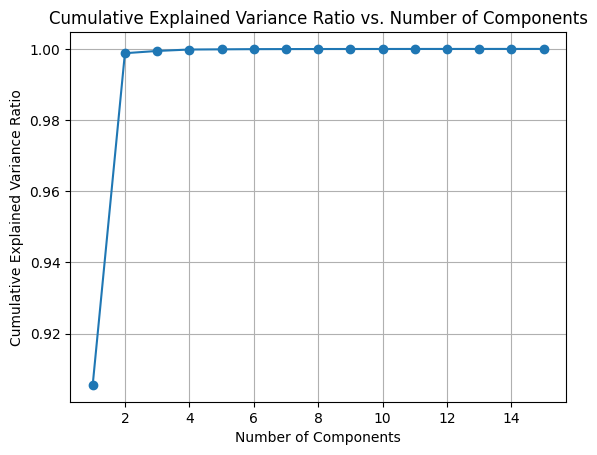

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15)

pca.fit(X_train_resampled)

#X_pca = pca.transform(X_train_resampled)

explained_variance_ratio = pca.explained_variance_ratio_

#singular_values = pca.singular_values_

cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
print("cumulative_variance_ratio:", cumulative_variance_ratio)

# Plot the cumulative explained variance ratio
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [ ]:
X_reduced = pca.transform(X_train_resampled)
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_train_resampled,
                                                                                    test_size=0.3,
                                                                                    stratify=y_train_resampled,
                                                                                    random_state=42)
print(X_train_reduced.shape,X_test_reduced.shape,y_train_reduced.shape,y_test_reduced.shape)

(10764, 15) (4614, 15) (10764,) (4614,)


**Decision Trees using the reduced PCA features**

Best Parameters:
{'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 8}

cross validation score:
[0.86948444 0.85137018 0.85137018 0.86344635 0.84526022]

#####################         Train results         #####################
f1 score: 0.8616221114635252

conf_matrix:
[[4483  899]
 [ 628 4754]]

precision score: 0.8409693967804706

recall score: 0.8833147528799703

auc_roc: 0.8734045045481719


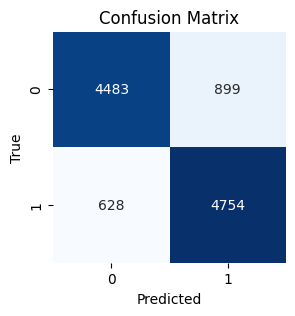

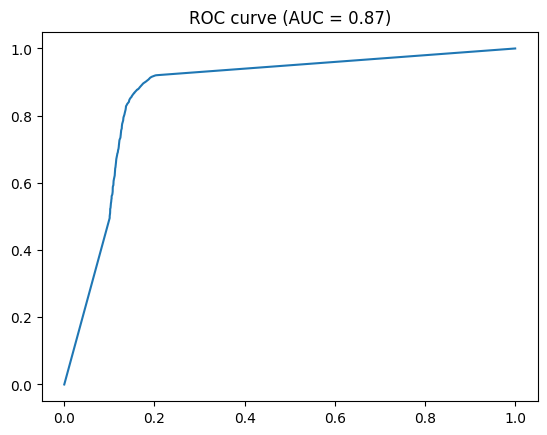


#####################         Test results         #####################
f1 score: 0.87450407183128

conf_matrix:
[[1919  388]
 [ 213 2094]]

precision score: 0.8436744560838034

recall score: 0.9076723016905072

auc_roc: 0.8858734343319901


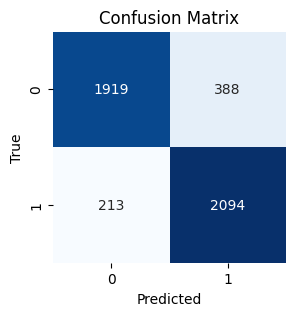

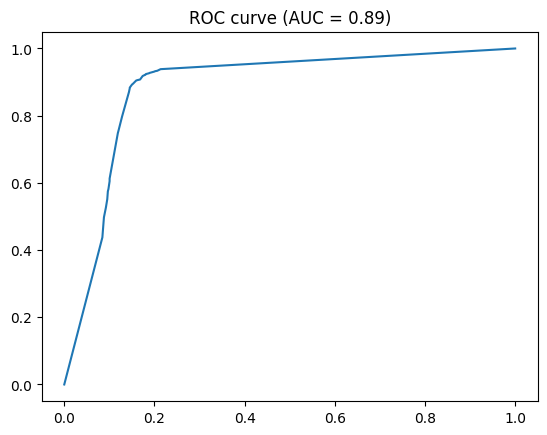

In [ ]:
DT_3_4 = DecisionTreeClassifier()

param_grid = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": randint(low=2, high=30),
    "min_samples_leaf": randint(low=1, high=5),
    "max_features": [None, "sqrt", "log2"],
}

random_search = RandomizedSearchCV(
    estimator = DT_3_4,
    param_distributions = param_grid,
    n_iter = 20,
    scoring = make_scorer(f1_score),
    cv = 5,
    random_state = 42
)

random_search.fit(X_train_reduced, y_train_reduced)

best_model_DT_3_4 = random_search.best_estimator_
best_params_DT_3_4 = random_search.best_params_

cross_val_score_DT_3_4 = cross_val_score(best_model_DT_3_4, X_train_reduced, y_train_reduced, cv=5)

print("Best Parameters:")
print(best_params_DT_3_4)
print()
print("cross validation score:")
print(cross_val_score_DT_3_4)
print()

y_train_pred_DT_3_4 = cross_val_predict(best_model_DT_3_4, X_train_reduced, y_train_reduced, cv=5)
y_train_pred_proba_DT_3_4 = cross_val_predict(best_model_DT_3_4, X_train_reduced, y_train_reduced, cv=5, method="predict_proba")[:, 1]

importance_DT_3_2 = best_model_DT_3_2.feature_importances_


print("#####################         Train results         #####################")
f1 = f1_score(y_train_reduced, y_train_pred_DT_3_4)
conf_matrix = confusion_matrix(y_train_reduced, y_train_pred_DT_3_4)
precision = precision_score(y_train_reduced, y_train_pred_DT_3_4)
recall = recall_score(y_train_reduced, y_train_pred_DT_3_4)
auc_roc = roc_auc_score(y_train_reduced, y_train_pred_proba_DT_3_4)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_train_reduced, y_train_pred_proba_DT_3_4)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()


y_test_pred_DT_3_4= best_model_DT_3_4.predict(X_test_reduced)
y_test_pred_proba_DT_3_4 = best_model_DT_3_4.predict_proba(X_test_reduced)[:,1]


print()
print("#####################         Test results         #####################")
f1 = f1_score(y_test_reduced, y_test_pred_DT_3_4)
auc_roc = roc_auc_score(y_test_reduced, y_test_pred_proba_DT_3_4)
conf_matrix = confusion_matrix(y_test_reduced, y_test_pred_DT_3_4)
precision = precision_score(y_test_reduced, y_test_pred_DT_3_4)
recall = recall_score(y_test_reduced, y_test_pred_DT_3_4)

print("f1 score:", f1)
print()
print("conf_matrix:")
print(conf_matrix)
print()
print("precision score:", precision)
print()
print("recall score:", recall)
print()
print("auc_roc:", auc_roc)

tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test_reduced, y_test_pred_proba_DT_3_4)
plt.plot(fpr, tpr)
plt.title("ROC curve (AUC = {:.2f})".format(auc_roc))
plt.show()

it seems that PCA trick overcame the overfit issue. We tried different number of components: [5, 10, 15, 20, 30, 40, 50] but the Decision Showed the best results when the number of components were 15. (Although 99% of explained variance were captured in the first 2 components)